[ 6.958736   3.6137748  7.621929   4.4307227  7.0209637  5.9953203
  6.639212   4.527039   6.2026777  5.5690675  6.251418   6.185321
  6.0196304  6.615302   6.9763513  6.3557816  5.603314   5.3856215
  5.697649   6.135385   5.38722    6.028666   6.101485   7.987162
  6.4409585  5.968725   6.183978   6.680595   5.825424   8.184014
  7.24476    6.4850354  7.1477118  7.685853   6.7126923  6.3719864
  6.430005   6.8842936  5.689851   6.8367877  6.507872   5.5784116
  8.179685   5.4002132 10.396509   6.77899    5.3748565  7.9285636
  6.877899   7.1732736  6.459869   5.354801   8.238991   6.1210775
  5.5245376  8.24445    5.7500095  5.1092157  5.3283153  6.292792
  6.792024   6.338078   5.691143   5.9245677]
[ 6.59796    3.4241824  7.0606923  4.1209974  7.152147   6.1396966
  6.3725595  4.422325   6.0592003  5.420556   5.5711412  6.0392494
  5.923421   6.7050705  7.1076546  6.6086516  5.5177608  5.1849084
  5.367672   5.9648232  5.4402146  5.769828   5.937371   7.461755
  6.0053     5.759284

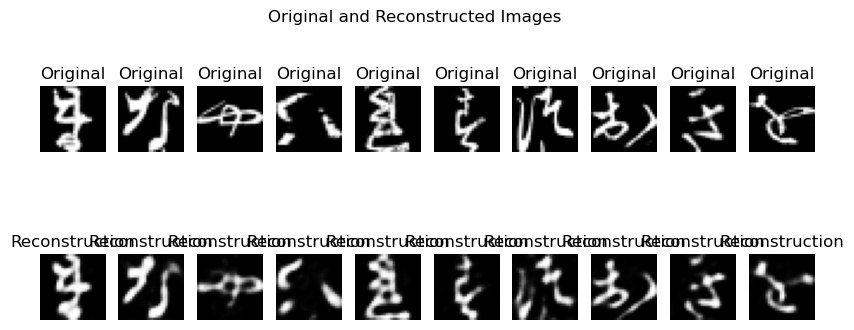

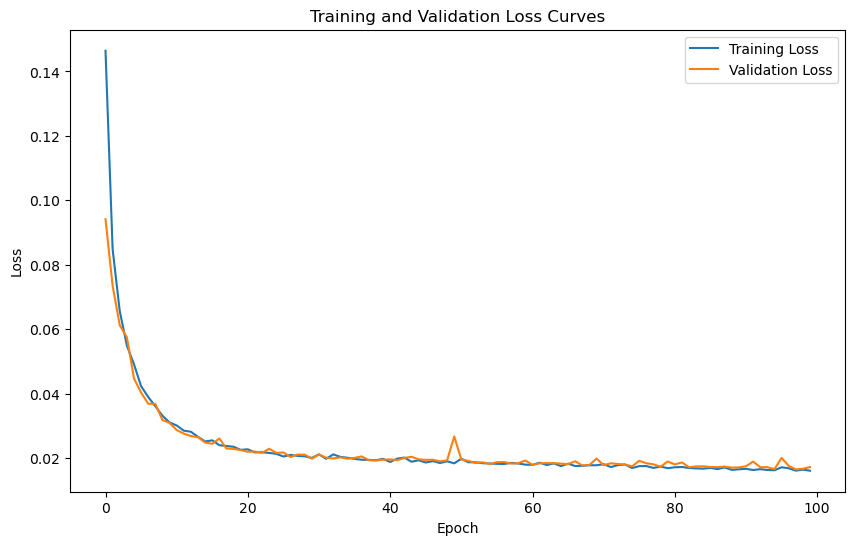

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the .npy file
file = 'encodings.npy'
encodings = np.load(file, allow_pickle=True).item()

# Extract '64' encoding for training and test sets
encoding_64_train = encodings[64][0]
encoding_64_test = encodings[64][1]

# Calculate the average encoding separately for training and test sets
average_encoding_train = np.mean(encoding_64_train, axis=0)
average_encoding_test = np.mean(encoding_64_test, axis=0)

print(average_encoding_train)
print(average_encoding_test)

def custom_regularizer(y_true, y_pred, average_encoding):
    # Calculate the distance between the current code and the average encoding
    distance = tf.reduce_sum(tf.square(y_pred - average_encoding), axis=-1)
    return 0.1 * tf.reduce_mean(distance)  # Adjust the multiplier (0.1) as needed

def build_stacked_autoencoder(input_dim, encoding_dim, activation='selu', average_encoding=None):
    # Encoder
    inputs = Input(shape=(input_dim,))
    dense_1 = Dense(800, activation=activation)(inputs)
    dense_2 = Dense(400, activation=activation)(dense_1)
    encoded_layer = Dense(encoding_dim, activation=activation, activity_regularizer=lambda x: custom_regularizer(x, x, average_encoding))(dense_2)

    # Decoder
    encoded_input = Input(shape=(encoding_dim,))
    l_dc0 = Dense(400, activation=activation)(encoded_input)
    l_dc1 = Dense(800, activation=activation)(l_dc0)
    l_dc2 = Dense(input_dim, activation='sigmoid')(l_dc1)

    # Models
    encoder = Model(inputs, encoded_layer, name='encoder')
    decoder = Model(encoded_input, l_dc2, name='decoder')
    autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')

    return encoder, decoder, autoencoder

# K-MNIST data preparation
def load_kmnist():
    data = {}
    data['x_train'] = np.load('./data/kmnist-train-imgs.npz')['arr_0']
    data['y_train'] = np.load('./data/kmnist-train-labels.npz')['arr_0']
    data['x_test'] = np.load('./data/kmnist-test-imgs.npz')['arr_0']
    data['y_test'] = np.load('./data/kmnist-test-labels.npz')['arr_0']
    return data

data = load_kmnist()

# Data preparation
x_train, x_val, y_train, y_val = train_test_split(data['x_train'], data['y_train'], test_size=0.2, random_state=42)
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = data['x_test'].astype('float32') / 255.0
y_test = data['y_test']

# Autoencoder parameters
enc_dim = 64
mlp_size = 4096
encoding_dim = enc_dim
activation = 'selu'


# Build and compile the stacked autoencoder for training set
encoder_train, decoder_train, autoencoder_train = build_stacked_autoencoder(input_dim=28*28, encoding_dim=encoding_dim, activation=activation, average_encoding=average_encoding_train)
autoencoder_train.compile(optimizer='adam', loss="mean_squared_error", run_eagerly=True)

# Model summary
autoencoder_train.summary()

# Flatten the input data to shape (None, 784)
x_train_flatten = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))

# Flatten the validation data to shape (None, 784)
x_val_flatten = x_val.reshape((len(x_val), np.prod(x_val.shape[1:])))

# Flatten the test data to shape (None, 784)
x_test_flatten = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


# Train the model for training set
history_train = autoencoder_train.fit(
    x_train_flatten, x_train_flatten,
    epochs=100,
    batch_size=2000,
    shuffle=True,
    validation_data=(x_val_flatten, x_val_flatten)
)


# Evaluate the model on the test set
evaluation_train = autoencoder_train.evaluate(x_train_flatten, x_train_flatten)
evaluation_test = autoencoder_train.evaluate(x_test_flatten, x_test_flatten)

# Report evaluation metrics
print("\nTraining Set - Reconstruction Error:", evaluation_train)
print("Test Set - Reconstruction Error:", evaluation_test)

# Visualize original and reconstructed images for a few examples
num_examples = 10
decoded_imgs = autoencoder_train.predict(x_val_flatten[:num_examples])

plt.figure(figsize=(10, 4))
for i in range(num_examples):
    # Original Images
    ax = plt.subplot(2, num_examples, i + 1)
    plt.imshow(x_val[i].reshape(28, 28), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Reconstructed Images
    ax = plt.subplot(2, num_examples, i + 1 + num_examples)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title('Reconstruction')
    plt.axis('off')
    
plt.suptitle('Original and Reconstructed Images')
plt.show()

# Plot training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(history_train.history['loss'], label='Training Loss')
plt.plot(history_train.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

[ 6.958736   3.6137748  7.621929   4.4307227  7.0209637  5.9953203
  6.639212   4.527039   6.2026777  5.5690675  6.251418   6.185321
  6.0196304  6.615302   6.9763513  6.3557816  5.603314   5.3856215
  5.697649   6.135385   5.38722    6.028666   6.101485   7.987162
  6.4409585  5.968725   6.183978   6.680595   5.825424   8.184014
  7.24476    6.4850354  7.1477118  7.685853   6.7126923  6.3719864
  6.430005   6.8842936  5.689851   6.8367877  6.507872   5.5784116
  8.179685   5.4002132 10.396509   6.77899    5.3748565  7.9285636
  6.877899   7.1732736  6.459869   5.354801   8.238991   6.1210775
  5.5245376  8.24445    5.7500095  5.1092157  5.3283153  6.292792
  6.792024   6.338078   5.691143   5.9245677]
[ 6.59796    3.4241824  7.0606923  4.1209974  7.152147   6.1396966
  6.3725595  4.422325   6.0592003  5.420556   5.5711412  6.0392494
  5.923421   6.7050705  7.1076546  6.6086516  5.5177608  5.1849084
  5.367672   5.9648232  5.4402146  5.769828   5.937371   7.461755
  6.0053     5.759284

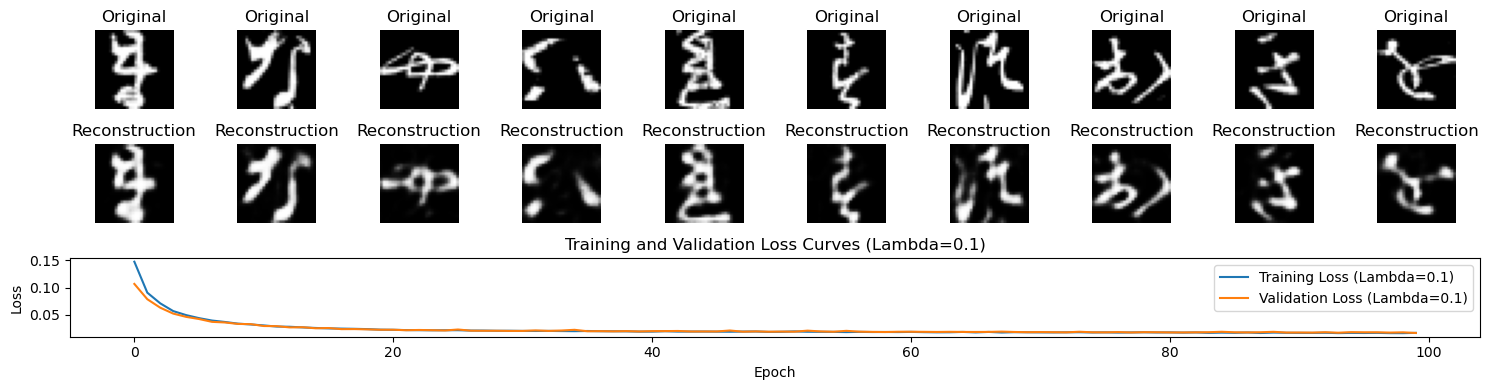

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 784)]             0         
                                                                 
 encoder (Functional)        (None, 64)                974064    
                                                                 
 decoder (Functional)        (None, 784)               974784    
                                                                 
Total params: 1,948,848
Trainable params: 1,948,848
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
24/24 [==============================] - 1s 37ms/step - loss: 0.1206 - val_loss: 0.0915
Epoch 2/100
24/24 [==============================] - 1s 31ms/step - loss: 0.0763 - val_loss: 0.0651
Epoch 3/100
24/24 [==============================] - 1s 30ms/step - loss: 0.0579 - val_loss: 0.0513
Epoch 4/1

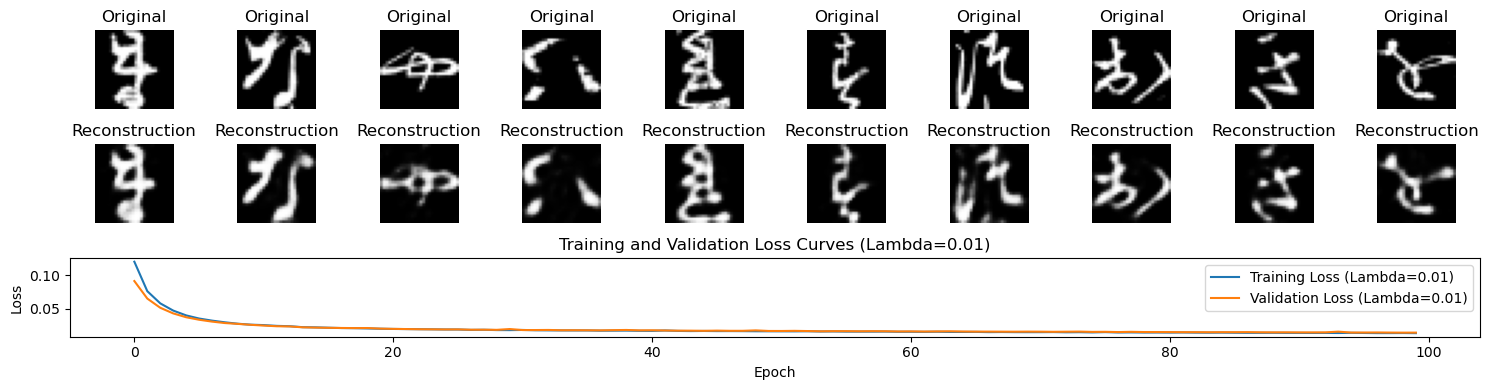

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 784)]             0         
                                                                 
 encoder (Functional)        (None, 64)                974064    
                                                                 
 decoder (Functional)        (None, 784)               974784    
                                                                 
Total params: 1,948,848
Trainable params: 1,948,848
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
24/24 [==============================] - 1s 33ms/step - loss: 0.1084 - val_loss: 0.0793
Epoch 2/100
24/24 [==============================] - 1s 29ms/step - loss: 0.0663 - val_loss: 0.0564
Epoch 3/100
24/24 [==============================] - 1s 30ms/step - loss: 0.0499 - val_loss: 0.0443
Epoch 4/1

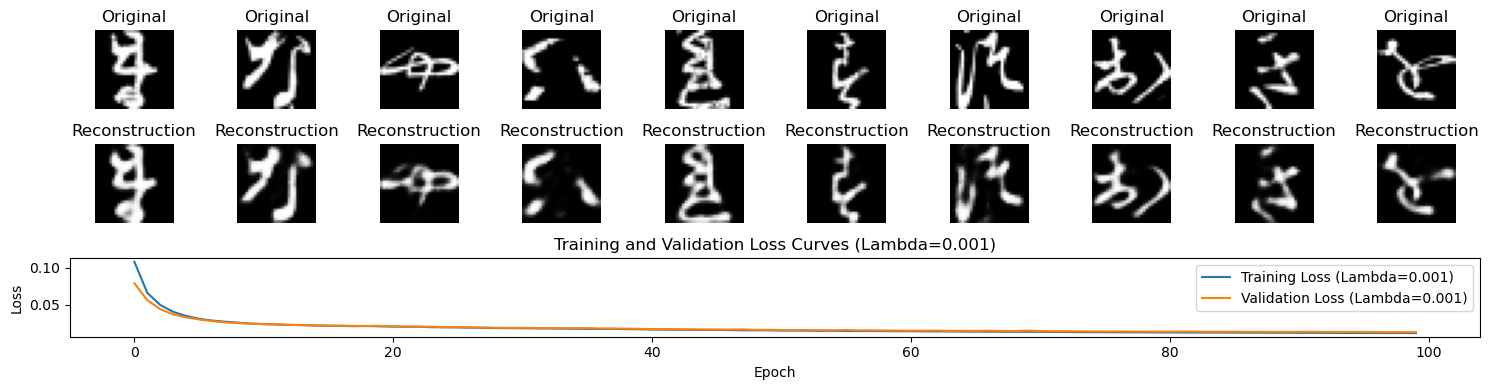

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the .npy file
file = 'encodings.npy'
encodings = np.load(file, allow_pickle=True).item()

# Extract '64' encoding for training and test sets
encoding_64_train = encodings[64][0]
encoding_64_test = encodings[64][1]

# Calculate the average encoding separately for training and test sets
average_encoding_train = np.mean(encoding_64_train, axis=0)
average_encoding_test = np.mean(encoding_64_test, axis=0)

print(average_encoding_train)
print(average_encoding_test)

def custom_regularizer(y_true, y_pred, average_encoding, lambda_values):
    total_loss = 0.0
    for lambda_value in lambda_values:
        # Calculate the distance between the current code and the average encoding
        distance = tf.reduce_sum(tf.square(y_pred - average_encoding), axis=-1)
        total_loss += lambda_value * tf.reduce_mean(distance)

    return total_loss / len(lambda_values)

def build_stacked_autoencoder(input_dim, encoding_dim, activation='selu', average_encoding=None, lambda_values=None):
    # Encoder
    inputs = Input(shape=(input_dim,))
    dense_1 = Dense(800, activation=activation)(inputs)
    dense_2 = Dense(400, activation=activation)(dense_1)
    encoded_layer = Dense(encoding_dim, activation=activation, activity_regularizer=lambda x: custom_regularizer(x, x, average_encoding, lambda_values))(dense_2)

    # Decoder
    encoded_input = Input(shape=(encoding_dim,))
    l_dc0 = Dense(400, activation=activation)(encoded_input)
    l_dc1 = Dense(800, activation=activation)(l_dc0)
    l_dc2 = Dense(input_dim, activation='sigmoid')(l_dc1)

    # Models
    encoder = Model(inputs, encoded_layer, name='encoder')
    decoder = Model(encoded_input, l_dc2, name='decoder')
    autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')

    return encoder, decoder, autoencoder

def plot_images_and_loss(history, decoded_imgs, x_val_flatten, lambda_value):
    # Visualize original and reconstructed images for a few examples
    num_examples = 10

    plt.figure(figsize=(15, 4))
    for i in range(num_examples):
        # Original Images
        ax = plt.subplot(3, num_examples, i + 1)
        plt.imshow(x_val_flatten[i].reshape(28, 28), cmap='gray')
        plt.title('Original')
        plt.axis('off')

        # Reconstructed Images
        ax = plt.subplot(3, num_examples, i + 1 + num_examples)
        plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
        plt.title('Reconstruction')
        plt.axis('off')

    # Plot training and validation loss curves
    ax = plt.subplot(3, 1, 3)
    ax.plot(history.history['loss'], label=f'Training Loss (Lambda={lambda_value})')
    ax.plot(history.history['val_loss'], label=f'Validation Loss (Lambda={lambda_value})')
    ax.set_title(f'Training and Validation Loss Curves (Lambda={lambda_value})')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()

    plt.tight_layout()
    plt.show()

def load_kmnist():
    data = {}
    data['x_train'] = np.load('./data/kmnist-train-imgs.npz')['arr_0']
    data['y_train'] = np.load('./data/kmnist-train-labels.npz')['arr_0']
    data['x_test'] = np.load('./data/kmnist-test-imgs.npz')['arr_0']
    data['y_test'] = np.load('./data/kmnist-test-labels.npz')['arr_0']
    return data

data = load_kmnist()

# Data preparation
x_train, x_val, y_train, y_val = train_test_split(data['x_train'], data['y_train'], test_size=0.2, random_state=42)
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = data['x_test'].astype('float32') / 255.0
y_test = data['y_test']

# Autoencoder parameters
enc_dim = 64
mlp_size = 4096
encoding_dim = enc_dim
activation = 'selu'

# Build and compile the stacked autoencoder for training set with multiple lambda values
lambda_values = [0.1, 0.01, 0.001]

for lambda_value in lambda_values:
    encoder_train, decoder_train, autoencoder_train = build_stacked_autoencoder(
        input_dim=28*28,
        encoding_dim=encoding_dim,
        activation=activation,
        average_encoding=average_encoding_train,
        lambda_values=[lambda_value]
    )
    autoencoder_train.compile(optimizer='adam', loss="mean_squared_error", run_eagerly=True)

    # Model summary
    autoencoder_train.summary()

    # Flatten the input data to shape (None, 784)
    x_train_flatten = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))

    # Flatten the validation data to shape (None, 784)
    x_val_flatten = x_val.reshape((len(x_val), np.prod(x_val.shape[1:])))

    # Flatten the test data to shape (None, 784)
    x_test_flatten = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

    # Train the model for training set
    history_train = autoencoder_train.fit(
        x_train_flatten, x_train_flatten,
        epochs=100,
        batch_size=2000,
        shuffle=True,
        validation_data=(x_val_flatten, x_val_flatten)
    )

    # Evaluate the model on the test set
    evaluation_train = autoencoder_train.evaluate(x_train_flatten, x_train_flatten)
    evaluation_test = autoencoder_train.evaluate(x_test_flatten, x_test_flatten)

    # Report evaluation metrics
    print("\nTraining Set - Reconstruction Error (Lambda={}):".format(lambda_value), evaluation_train)
    print("Test Set - Reconstruction Error (Lambda={}):".format(lambda_value), evaluation_test)

    # Visualize original and reconstructed images for a few examples
    decoded_imgs = autoencoder_train.predict(x_val_flatten)
    plot_images_and_loss(history_train, decoded_imgs, x_val_flatten, lambda_value)

[ 6.958736   3.6137748  7.621929   4.4307227  7.0209637  5.9953203
  6.639212   4.527039   6.2026777  5.5690675  6.251418   6.185321
  6.0196304  6.615302   6.9763513  6.3557816  5.603314   5.3856215
  5.697649   6.135385   5.38722    6.028666   6.101485   7.987162
  6.4409585  5.968725   6.183978   6.680595   5.825424   8.184014
  7.24476    6.4850354  7.1477118  7.685853   6.7126923  6.3719864
  6.430005   6.8842936  5.689851   6.8367877  6.507872   5.5784116
  8.179685   5.4002132 10.396509   6.77899    5.3748565  7.9285636
  6.877899   7.1732736  6.459869   5.354801   8.238991   6.1210775
  5.5245376  8.24445    5.7500095  5.1092157  5.3283153  6.292792
  6.792024   6.338078   5.691143   5.9245677]
[ 6.59796    3.4241824  7.0606923  4.1209974  7.152147   6.1396966
  6.3725595  4.422325   6.0592003  5.420556   5.5711412  6.0392494
  5.923421   6.7050705  7.1076546  6.6086516  5.5177608  5.1849084
  5.367672   5.9648232  5.4402146  5.769828   5.937371   7.461755
  6.0053     5.759284

2023-11-27 22:26:43.948539: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-27 22:26:45.465102: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78911 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:87:00.0, compute capability: 8.0
2023-11-27 22:26:45.469213: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78911 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:90:00.0, compute capability: 8.0


Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 encoder (Functional)        (None, 64)                974064    
                                                                 
 decoder (Functional)        (None, 784)               974784    
                                                                 
Total params: 1,948,848
Trainable params: 1,948,848
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
 16/188 [=>............................] - ETA: 1s - loss: 0.1548

2023-11-27 22:26:47.326067: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


188/188 [==============================] - 3s 12ms/step - loss: 0.0636 - val_loss: 0.0339
Epoch 2/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0287 - val_loss: 0.0258
Epoch 3/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0233 - val_loss: 0.0226
Epoch 4/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0214 - val_loss: 0.0212
Epoch 5/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0204 - val_loss: 0.0202
Epoch 6/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0197 - val_loss: 0.0197
Epoch 7/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0193 - val_loss: 0.0198
Epoch 8/100
188/188 [==============================] - 2s 11ms/step - loss: 0.0189 - val_loss: 0.0192
Epoch 9/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0185 - val_loss: 0.0189
Epoch 10/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0182 - val_loss

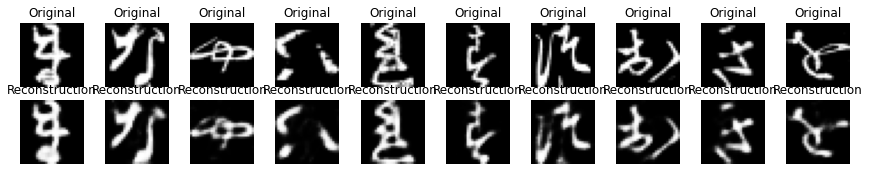

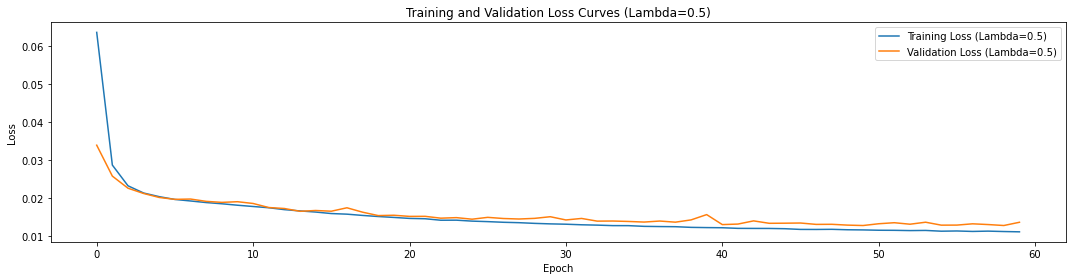

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 784)]             0         
                                                                 
 encoder (Functional)        (None, 64)                974064    
                                                                 
 decoder (Functional)        (None, 784)               974784    
                                                                 
Total params: 1,948,848
Trainable params: 1,948,848
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0593 - val_loss: 0.0339
Epoch 2/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0283 - val_loss: 0.0247
Epoch 3/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0225 - val_loss: 0.0215
Epo

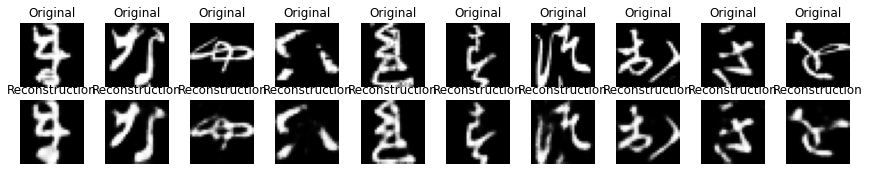

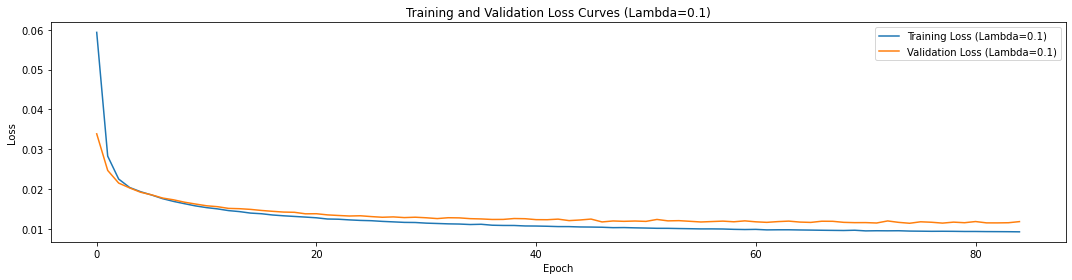

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 784)]             0         
                                                                 
 encoder (Functional)        (None, 64)                974064    
                                                                 
 decoder (Functional)        (None, 784)               974784    
                                                                 
Total params: 1,948,848
Trainable params: 1,948,848
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0544 - val_loss: 0.0306
Epoch 2/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0257 - val_loss: 0.0223
Epoch 3/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0207 - val_loss: 0.0197
Epo

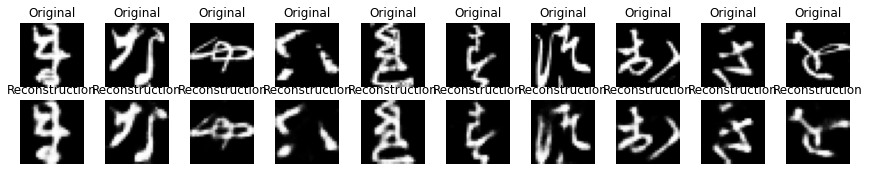

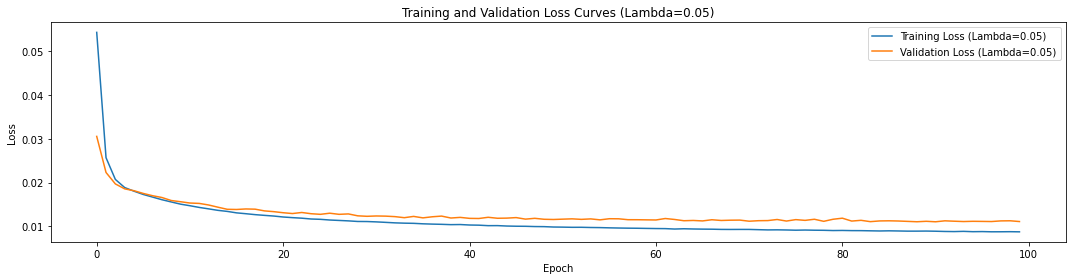

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 784)]             0         
                                                                 
 encoder (Functional)        (None, 64)                974064    
                                                                 
 decoder (Functional)        (None, 784)               974784    
                                                                 
Total params: 1,948,848
Trainable params: 1,948,848
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0528 - val_loss: 0.0297
Epoch 2/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0269 - val_loss: 0.0252
Epoch 3/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0236 - val_loss: 0.0230
Epo

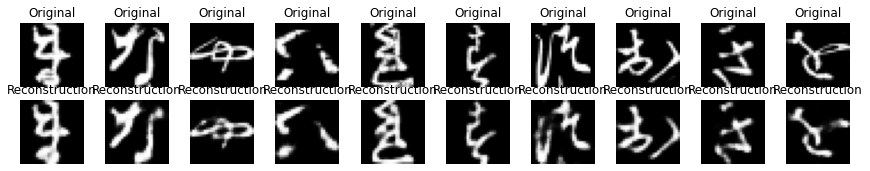

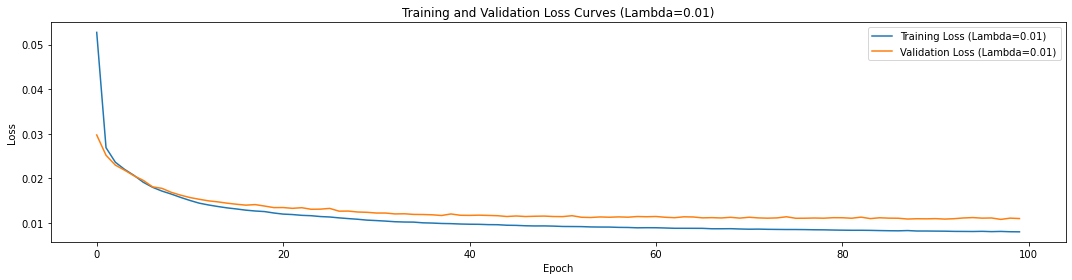

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 784)]             0         
                                                                 
 encoder (Functional)        (None, 64)                974064    
                                                                 
 decoder (Functional)        (None, 784)               974784    
                                                                 
Total params: 1,948,848
Trainable params: 1,948,848
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
188/188 [==============================] - 2s 13ms/step - loss: 0.0523 - val_loss: 0.0305
Epoch 2/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0277 - val_loss: 0.0262
Epoch 3/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0248 - val_loss: 0.0241
Epo

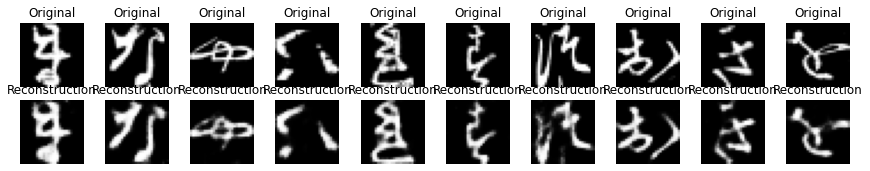

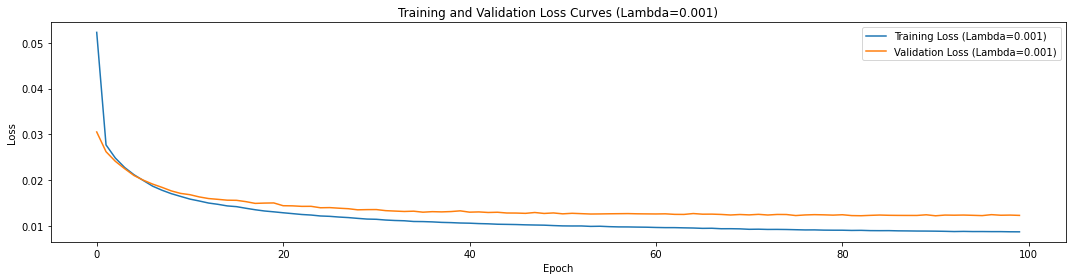

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 784)]             0         
                                                                 
 encoder (Functional)        (None, 64)                974064    
                                                                 
 decoder (Functional)        (None, 784)               974784    
                                                                 
Total params: 1,948,848
Trainable params: 1,948,848
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0498 - val_loss: 0.0281
Epoch 2/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0252 - val_loss: 0.0237
Epoch 3/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0227 - val_loss: 0.0220
Epo

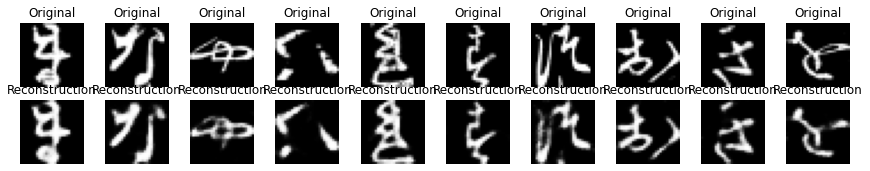

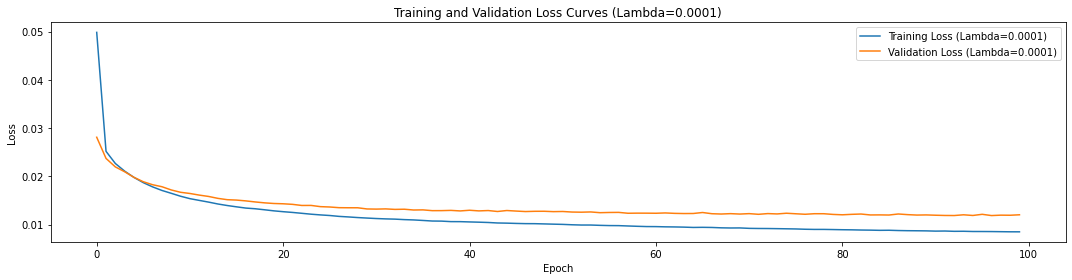

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the .npy file
file = 'encodings.npy'
encodings = np.load(file, allow_pickle=True).item()

# Extract '64' encoding for training and test sets
encoding_64_train = encodings[64][0]
encoding_64_test = encodings[64][1]

# Calculate the average encoding separately for training and test sets
average_encoding_train = np.mean(encoding_64_train, axis=0)
average_encoding_test = np.mean(encoding_64_test, axis=0)

print(average_encoding_train)
print(average_encoding_test)

def custom_regularizer(y_true, y_pred, average_encoding, lambda_values):
    total_loss_L = 0.0
    total_loss_R = 0.0

    if not isinstance(lambda_values, list):
        lambda_values = [lambda_values]
        
    for lambda_value in lambda_values:
        # Reconstruction error (L)
        loss_L = tf.reduce_mean(tf.square(y_pred - y_true))

        # Additional regularization error (R)
        loss_R = lambda_value * tf.reduce_mean(tf.square(y_pred - average_encoding))

        total_loss_L += loss_L
        total_loss_R += loss_R

    # Return the sum of reconstruction and regularization errors
    return total_loss_L / len(lambda_values) + total_loss_R / len(lambda_values)

def build_stacked_autoencoder(input_dim, encoding_dim, activation='selu', average_encoding=None, lambda_values=None):
    # Encoder
    inputs = Input(shape=(input_dim,))
    dense_1 = Dense(800, activation=activation)(inputs)
    dense_2 = Dense(400, activation=activation)(dense_1)
    encoded_layer = Dense(encoding_dim, activation=activation, activity_regularizer=lambda x: custom_regularizer(x, x, average_encoding, lambda_values))(dense_2)

    # Decoder
    encoded_input = Input(shape=(encoding_dim,))
    l_dc0 = Dense(400, activation=activation)(encoded_input)
    l_dc1 = Dense(800, activation=activation)(l_dc0)
    l_dc2 = Dense(input_dim, activation='sigmoid')(l_dc1)

    # Models
    encoder = Model(inputs, encoded_layer, name='encoder')
    decoder = Model(encoded_input, l_dc2, name='decoder')
    autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')

    return encoder, decoder, autoencoder

def plot_images_and_loss(history, decoded_imgs, x_val_flatten, lambda_value):
    # Visualize original and reconstructed images for a few examples
    num_examples = 10

    plt.figure(figsize=(15, 4))
    for i in range(num_examples):
        # Original Images
        ax = plt.subplot(3, num_examples, i + 1)
        plt.imshow(x_val_flatten[i].reshape(28, 28), cmap='gray')
        plt.title('Original')
        plt.axis('off')

        # Reconstructed Images
        ax = plt.subplot(3, num_examples, i + 1 + num_examples)
        plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
        plt.title('Reconstruction')
        plt.axis('off')

    # Plot training and validation loss curves
    plt.figure(figsize=(15, 4))
    ax = plt.subplot(1, 1, 1)
    ax.plot(history.history['loss'], label=f'Training Loss (Lambda={lambda_value})')
    ax.plot(history.history['val_loss'], label=f'Validation Loss (Lambda={lambda_value})')
    ax.set_title(f'Training and Validation Loss Curves (Lambda={lambda_value})')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()

    plt.tight_layout()
    plt.show()

def load_kmnist():
    data = {}
    data['x_train'] = np.load('./data/kmnist-train-imgs.npz')['arr_0']
    data['y_train'] = np.load('./data/kmnist-train-labels.npz')['arr_0']
    data['x_test'] = np.load('./data/kmnist-test-imgs.npz')['arr_0']
    data['y_test'] = np.load('./data/kmnist-test-labels.npz')['arr_0']
    return data

data = load_kmnist()

x_train, x_val, y_train, y_val = train_test_split(data['x_train'], data['y_train'], test_size=0.2, random_state=42)
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = data['x_test'].astype('float32') / 255.0
y_test = data['y_test']

# Autoencoder parameters
enc_dim = 64
mlp_size = 4096
encoding_dim = enc_dim
activation = 'selu'

# Build and compile the stacked autoencoder for training set with multiple lambda values
lambda_values = [0.5, 0.1, 0.05, 0.01, 0.001, 0.0001]

for lambda_value in lambda_values:
    encoder_train, decoder_train, autoencoder_train = build_stacked_autoencoder(
        input_dim=28*28,
        encoding_dim=encoding_dim,
        activation=activation,
        average_encoding=average_encoding_train,
        lambda_values=[lambda_value]
    )
    autoencoder_train.compile(optimizer='adam', loss="mean_squared_error", run_eagerly=True)

    # Model summary
    autoencoder_train.summary()

    # Flatten the input data to shape (None, 784)
    x_train_flatten = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))

    # Flatten the validation data to shape (None, 784)
    x_val_flatten = x_val.reshape((len(x_val), np.prod(x_val.shape[1:])))

    # Flatten the test data to shape (None, 784)
    x_test_flatten = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

    # Define early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Stop training when validation loss has stopped improving
        patience=10,          # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
    )
    
    # Train the model for training set
    history_train = autoencoder_train.fit(
        x_train_flatten, x_train_flatten,
        epochs=100,
        batch_size=256,
        shuffle=True,
        validation_data=(x_val_flatten, x_val_flatten),
        callbacks=[early_stopping]  # Add early stopping callback
    )

    # Evaluate the model on the test set
    evaluation_train = autoencoder_train.evaluate(x_train_flatten, x_train_flatten)
    evaluation_test = autoencoder_train.evaluate(x_test_flatten, x_test_flatten)

    # Report evaluation metrics
    print(f"\nTraining Set - Loss (Lambda={lambda_value}): {evaluation_train}")
    print(f"Test Set - Loss (Lambda={lambda_value}): {evaluation_test}")

    # Visualize original and reconstructed images for a few examples
    decoded_imgs = autoencoder_train.predict(x_val_flatten)
    plot_images_and_loss(history_train, decoded_imgs, x_val_flatten, lambda_value)

[ 6.958736   3.6137748  7.621929   4.4307227  7.0209637  5.9953203
  6.639212   4.527039   6.2026777  5.5690675  6.251418   6.185321
  6.0196304  6.615302   6.9763513  6.3557816  5.603314   5.3856215
  5.697649   6.135385   5.38722    6.028666   6.101485   7.987162
  6.4409585  5.968725   6.183978   6.680595   5.825424   8.184014
  7.24476    6.4850354  7.1477118  7.685853   6.7126923  6.3719864
  6.430005   6.8842936  5.689851   6.8367877  6.507872   5.5784116
  8.179685   5.4002132 10.396509   6.77899    5.3748565  7.9285636
  6.877899   7.1732736  6.459869   5.354801   8.238991   6.1210775
  5.5245376  8.24445    5.7500095  5.1092157  5.3283153  6.292792
  6.792024   6.338078   5.691143   5.9245677]
[ 6.59796    3.4241824  7.0606923  4.1209974  7.152147   6.1396966
  6.3725595  4.422325   6.0592003  5.420556   5.5711412  6.0392494
  5.923421   6.7050705  7.1076546  6.6086516  5.5177608  5.1849084
  5.367672   5.9648232  5.4402146  5.769828   5.937371   7.461755
  6.0053     5.759284

2023-11-27 23:33:34.104739: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-27 23:33:35.425243: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78911 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:87:00.0, compute capability: 8.0
2023-11-27 23:33:35.427016: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78911 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:90:00.0, compute capability: 8.0


Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 encoder (Functional)        (None, 64)                974064    
                                                                 
 decoder (Functional)        (None, 784)               974784    
                                                                 
Total params: 1,948,848
Trainable params: 1,948,848
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
 16/188 [=>............................] - ETA: 1s - loss: 0.1572

2023-11-27 23:33:37.279506: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


188/188 [==============================] - 3s 12ms/step - loss: 0.0634 - val_loss: 0.0339
Epoch 2/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0279 - val_loss: 0.0252
Epoch 3/100
188/188 [==============================] - 2s 11ms/step - loss: 0.0228 - val_loss: 0.0215
Epoch 4/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0212 - val_loss: 0.0208
Epoch 5/100
188/188 [==============================] - 2s 11ms/step - loss: 0.0203 - val_loss: 0.0206
Epoch 6/100
188/188 [==============================] - 2s 11ms/step - loss: 0.0197 - val_loss: 0.0198
Epoch 7/100
188/188 [==============================] - 2s 11ms/step - loss: 0.0192 - val_loss: 0.0194
Epoch 8/100
188/188 [==============================] - 2s 11ms/step - loss: 0.0188 - val_loss: 0.0193
Epoch 9/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0183 - val_loss: 0.0188
Epoch 10/100
188/188 [==============================] - 2s 11ms/step - loss: 0.0179 - val_loss

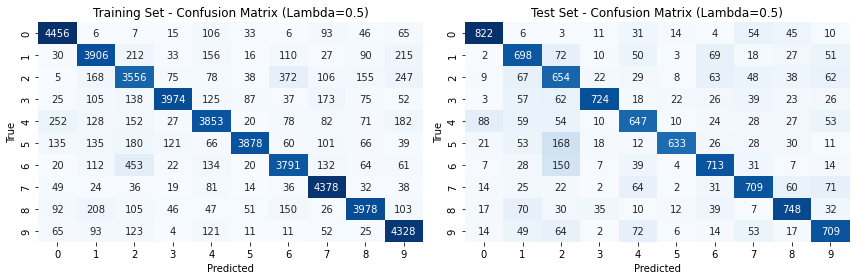

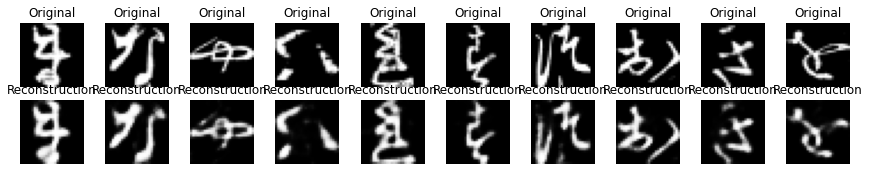

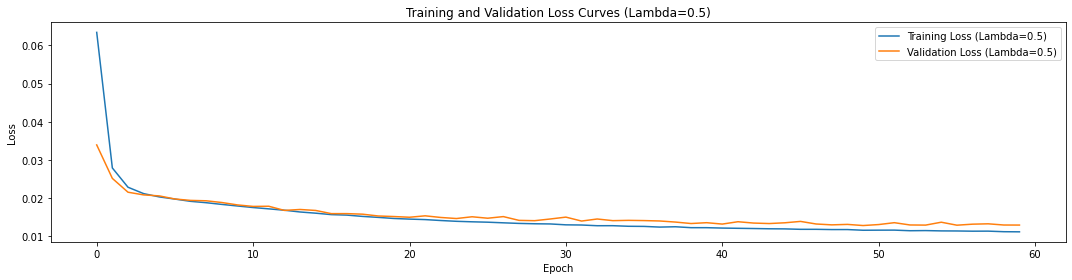

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 784)]             0         
                                                                 
 encoder (Functional)        (None, 64)                974064    
                                                                 
 decoder (Functional)        (None, 784)               974784    
                                                                 
Total params: 1,948,848
Trainable params: 1,948,848
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0585 - val_loss: 0.0316
Epoch 2/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0268 - val_loss: 0.0242
Epoch 3/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0219 - val_loss: 0.0209
Epo

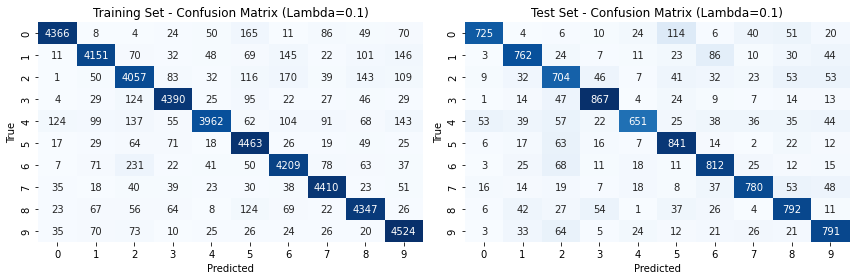

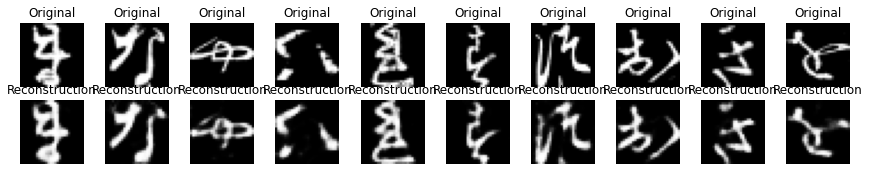

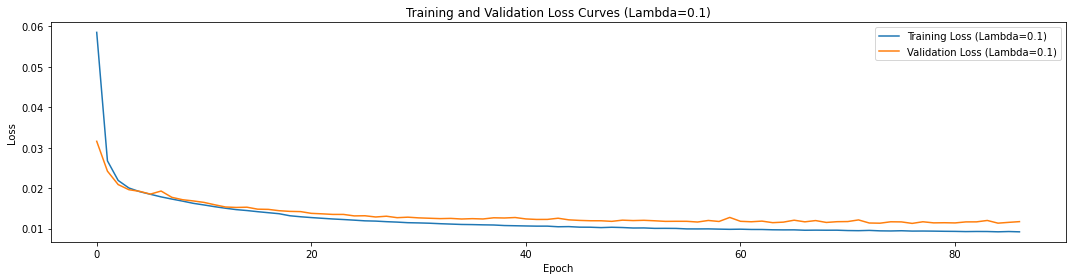

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 784)]             0         
                                                                 
 encoder (Functional)        (None, 64)                974064    
                                                                 
 decoder (Functional)        (None, 784)               974784    
                                                                 
Total params: 1,948,848
Trainable params: 1,948,848
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0549 - val_loss: 0.0309
Epoch 2/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0260 - val_loss: 0.0229
Epoch 3/100
188/188 [==============================] - 2s 11ms/step - loss: 0.0212 - val_loss: 0.0202
Epo

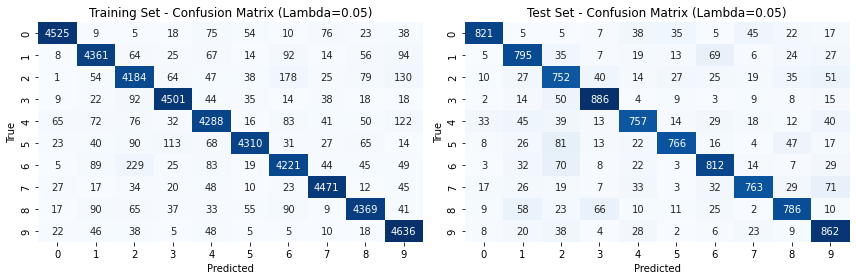

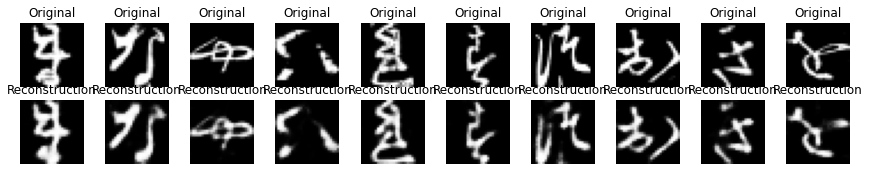

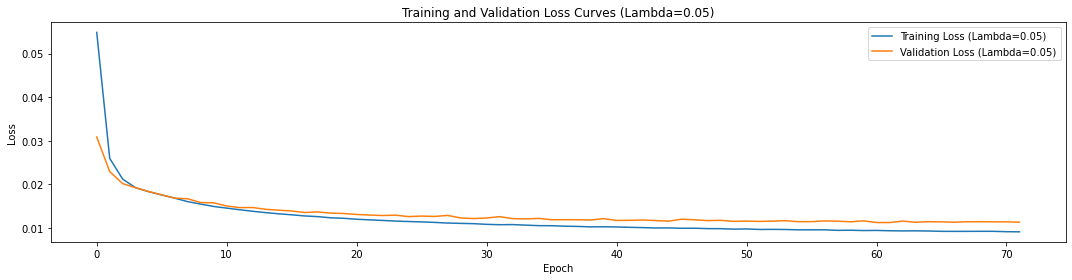

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 784)]             0         
                                                                 
 encoder (Functional)        (None, 64)                974064    
                                                                 
 decoder (Functional)        (None, 784)               974784    
                                                                 
Total params: 1,948,848
Trainable params: 1,948,848
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0521 - val_loss: 0.0302
Epoch 2/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0273 - val_loss: 0.0261
Epoch 3/100
188/188 [==============================] - 2s 11ms/step - loss: 0.0248 - val_loss: 0.0245
Epo

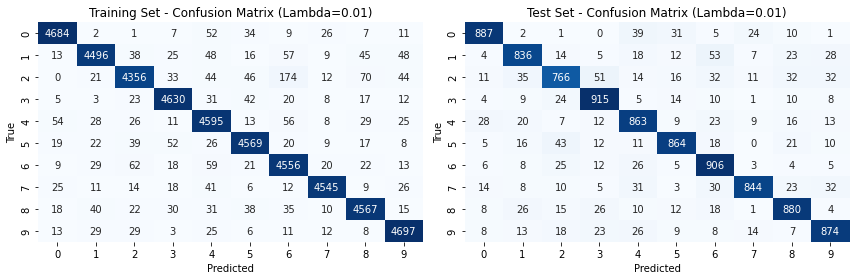

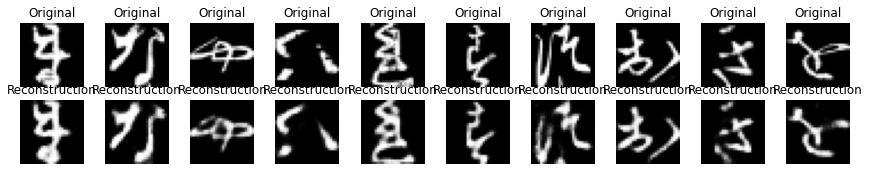

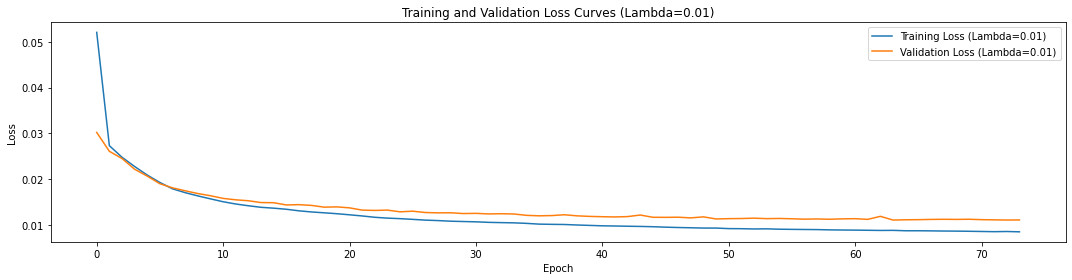

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 784)]             0         
                                                                 
 encoder (Functional)        (None, 64)                974064    
                                                                 
 decoder (Functional)        (None, 784)               974784    
                                                                 
Total params: 1,948,848
Trainable params: 1,948,848
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0489 - val_loss: 0.0269
Epoch 2/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0246 - val_loss: 0.0233
Epoch 3/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0224 - val_loss: 0.0223
Epo

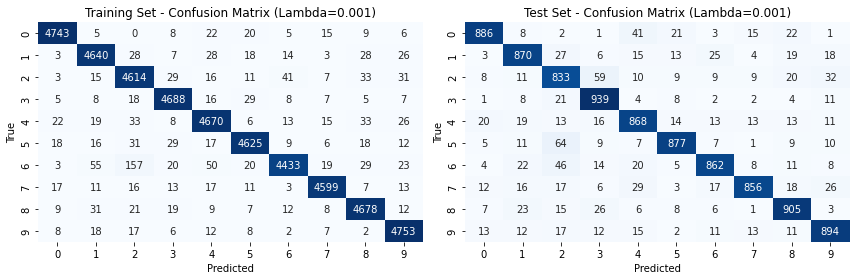

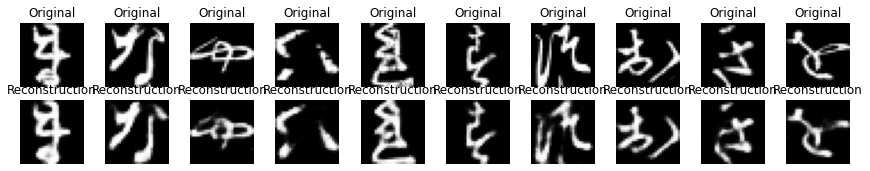

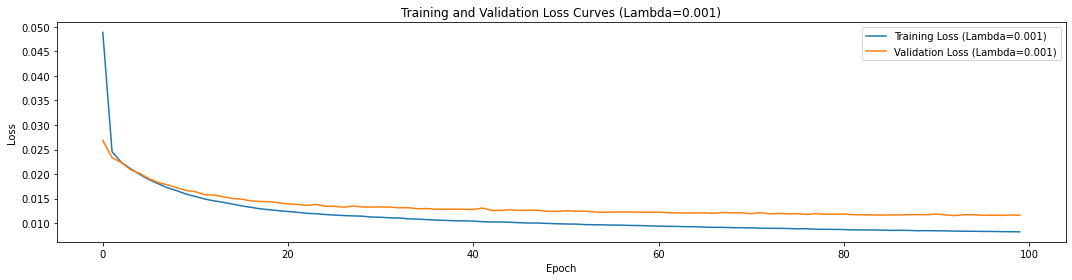

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 784)]             0         
                                                                 
 encoder (Functional)        (None, 64)                974064    
                                                                 
 decoder (Functional)        (None, 784)               974784    
                                                                 
Total params: 1,948,848
Trainable params: 1,948,848
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0502 - val_loss: 0.0275
Epoch 2/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0247 - val_loss: 0.0233
Epoch 3/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0221 - val_loss: 0.0213
Epo

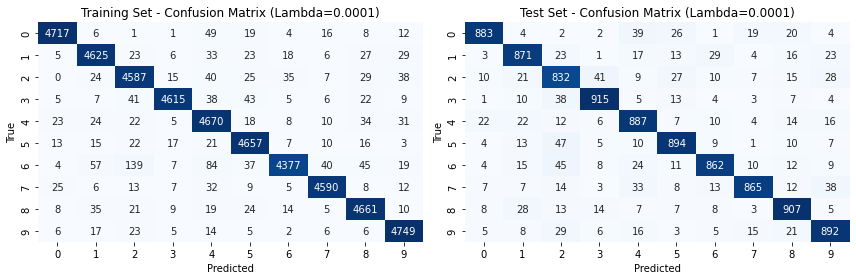

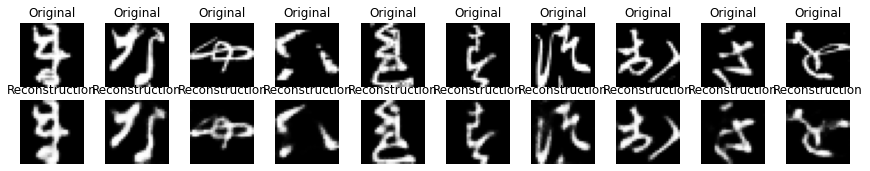

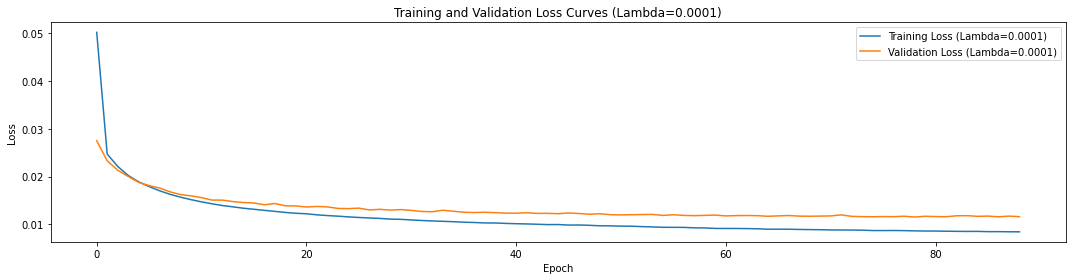

In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Load the .npy file
file = 'encodings.npy'
encodings = np.load(file, allow_pickle=True).item()

# Extract '64' encoding for training and test sets
encoding_64_train = encodings[64][0]
encoding_64_test = encodings[64][1]

# Calculate the average encoding separately for training and test sets
average_encoding_train = np.mean(encoding_64_train, axis=0)
average_encoding_test = np.mean(encoding_64_test, axis=0)

print(average_encoding_train)
print(average_encoding_test)

def custom_regularizer(y_true, y_pred, average_encoding, lambda_values):
    total_loss_L = 0.0
    total_loss_R = 0.0

    if not isinstance(lambda_values, list):
        lambda_values = [lambda_values]
        
    for lambda_value in lambda_values:
        # Reconstruction error (L)
        loss_L = tf.reduce_mean(tf.square(y_pred - y_true))

        # Additional regularization error (R)
        loss_R = lambda_value * tf.reduce_mean(tf.square(y_pred - average_encoding))

        total_loss_L += loss_L
        total_loss_R += loss_R

    # Return the sum of reconstruction and regularization errors
    return total_loss_L / len(lambda_values) + total_loss_R / len(lambda_values)

def build_stacked_autoencoder(input_dim, encoding_dim, activation='selu', average_encoding=None, lambda_values=None):
    # Encoder
    inputs = Input(shape=(input_dim,))
    dense_1 = Dense(800, activation=activation)(inputs)
    dense_2 = Dense(400, activation=activation)(dense_1)
    encoded_layer = Dense(encoding_dim, activation=activation, activity_regularizer=lambda x: custom_regularizer(x, x, average_encoding, lambda_values))(dense_2)

    # Decoder
    encoded_input = Input(shape=(encoding_dim,))
    l_dc0 = Dense(400, activation=activation)(encoded_input)
    l_dc1 = Dense(800, activation=activation)(l_dc0)
    l_dc2 = Dense(input_dim, activation='sigmoid')(l_dc1)

    # Models
    encoder = Model(inputs, encoded_layer, name='encoder')
    decoder = Model(encoded_input, l_dc2, name='decoder')
    autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')

    return encoder, decoder, autoencoder

def plot_images_and_loss(history, decoded_imgs, x_val_flatten, lambda_value):
    # Visualize original and reconstructed images for a few examples
    num_examples = 10

    plt.figure(figsize=(15, 4))
    for i in range(num_examples):
        # Original Images
        ax = plt.subplot(3, num_examples, i + 1)
        plt.imshow(x_val_flatten[i].reshape(28, 28), cmap='gray')
        plt.title('Original')
        plt.axis('off')

        # Reconstructed Images
        ax = plt.subplot(3, num_examples, i + 1 + num_examples)
        plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
        plt.title('Reconstruction')
        plt.axis('off')

    # Plot training and validation loss curves
    plt.figure(figsize=(15, 4))
    ax = plt.subplot(1, 1, 1)
    ax.plot(history.history['loss'], label=f'Training Loss (Lambda={lambda_value})')
    ax.plot(history.history['val_loss'], label=f'Validation Loss (Lambda={lambda_value})')
    ax.set_title(f'Training and Validation Loss Curves (Lambda={lambda_value})')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()

    plt.tight_layout()
    plt.show()

def load_kmnist():
    data = {}
    data['x_train'] = np.load('./data/kmnist-train-imgs.npz')['arr_0']
    data['y_train'] = np.load('./data/kmnist-train-labels.npz')['arr_0']
    data['x_test'] = np.load('./data/kmnist-test-imgs.npz')['arr_0']
    data['y_test'] = np.load('./data/kmnist-test-labels.npz')['arr_0']
    return data

data = load_kmnist()

x_train, x_val, y_train, y_val = train_test_split(data['x_train'], data['y_train'], test_size=0.2, random_state=42)
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = data['x_test'].astype('float32') / 255.0
y_test = data['y_test']

# Autoencoder parameters
enc_dim = 64
mlp_size = 4096
encoding_dim = enc_dim
activation = 'selu'

# Build and compile the stacked autoencoder for training set with multiple lambda values
lambda_values = [0.5, 0.1, 0.05, 0.01, 0.001, 0.0001]

for lambda_value in lambda_values:
    encoder_train, decoder_train, autoencoder_train = build_stacked_autoencoder(
        input_dim=28*28,
        encoding_dim=encoding_dim,
        activation=activation,
        average_encoding=average_encoding_train,
        lambda_values=[lambda_value]
    )
    autoencoder_train.compile(optimizer='adam', loss="mean_squared_error", run_eagerly=True)

    # Model summary
    autoencoder_train.summary()

    # Flatten the input data to shape (None, 784)
    x_train_flatten = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))

    # Flatten the validation data to shape (None, 784)
    x_val_flatten = x_val.reshape((len(x_val), np.prod(x_val.shape[1:])))

    # Flatten the test data to shape (None, 784)
    x_test_flatten = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

    # Convert labels to one-hot encoding for training and testing sets
    y_train_one_hot = to_categorical(y_train)
    y_test_one_hot = to_categorical(y_test)
    
    # Define early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Stop training when validation loss has stopped improving
        patience=10,          # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
    )
    
    # Train the model for training set
    history_train = autoencoder_train.fit(
        x_train_flatten, x_train_flatten,
        epochs=100,
        batch_size=256,
        shuffle=True,
        validation_data=(x_val_flatten, x_val_flatten),
        callbacks=[early_stopping]  # Add early stopping callback
    )

    # Evaluate the model on the test set
    evaluation_train = autoencoder_train.evaluate(x_train_flatten, x_train_flatten)
    evaluation_test = autoencoder_train.evaluate(x_test_flatten, x_test_flatten)

    # Report evaluation metrics
    print(f"\nTraining Set - Loss (Lambda={lambda_value}): {evaluation_train}")
    print(f"Test Set - Loss (Lambda={lambda_value}): {evaluation_test}")

    # Encode the training and testing data
    encoded_train = encoder_train.predict(x_train_flatten)
    encoded_test = encoder_train.predict(x_test_flatten)

    num_classes = 10
    # Train a simple classifier
    classifier = tf.keras.Sequential([
        Dense(128, activation='relu', input_shape=(encoding_dim,)),
        Dense(num_classes, activation='softmax')
    ])
    classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the classifier
    classifier.fit(encoded_train, y_train, epochs=50, batch_size=256, validation_data=(encoded_test, y_test), callbacks=[early_stopping])

    # Predictions
    y_train_pred = np.argmax(classifier.predict(encoded_train), axis=1)
    y_test_pred = np.argmax(classifier.predict(encoded_test), axis=1)

    # Confusion matrices
    cm_train = confusion_matrix(y_train, y_train_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)

    print(f'Training Set - Confusion Matrix (Lambda={lambda_value})')
    print(cm_train)
    print(f'\nTesting Set - Confusion Matrix (Lambda={lambda_value})')
    print(cm_test)

    # Plot confusion matrices
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm_train, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.title(f'Training Set - Confusion Matrix (Lambda={lambda_value})')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.subplot(1, 2, 2)
    sns.heatmap(cm_test, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.title(f'Test Set - Confusion Matrix (Lambda={lambda_value})')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.tight_layout()
    plt.show()
    
    # Visualize original and reconstructed images for a few examples
    decoded_imgs = autoencoder_train.predict(x_val_flatten)
    plot_images_and_loss(history_train, decoded_imgs, x_val_flatten, lambda_value)

[ 6.958736   3.6137748  7.621929   4.4307227  7.0209637  5.9953203
  6.639212   4.527039   6.2026777  5.5690675  6.251418   6.185321
  6.0196304  6.615302   6.9763513  6.3557816  5.603314   5.3856215
  5.697649   6.135385   5.38722    6.028666   6.101485   7.987162
  6.4409585  5.968725   6.183978   6.680595   5.825424   8.184014
  7.24476    6.4850354  7.1477118  7.685853   6.7126923  6.3719864
  6.430005   6.8842936  5.689851   6.8367877  6.507872   5.5784116
  8.179685   5.4002132 10.396509   6.77899    5.3748565  7.9285636
  6.877899   7.1732736  6.459869   5.354801   8.238991   6.1210775
  5.5245376  8.24445    5.7500095  5.1092157  5.3283153  6.292792
  6.792024   6.338078   5.691143   5.9245677]
[ 6.59796    3.4241824  7.0606923  4.1209974  7.152147   6.1396966
  6.3725595  4.422325   6.0592003  5.420556   5.5711412  6.0392494
  5.923421   6.7050705  7.1076546  6.6086516  5.5177608  5.1849084
  5.367672   5.9648232  5.4402146  5.769828   5.937371   7.461755
  6.0053     5.759284

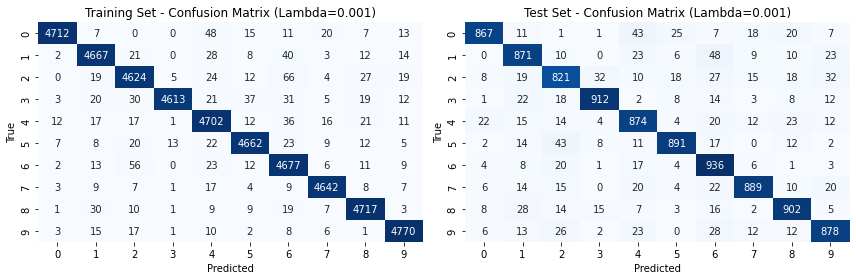

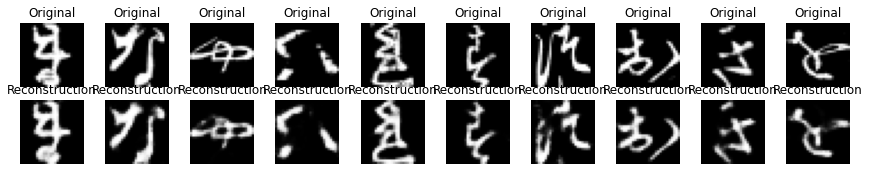

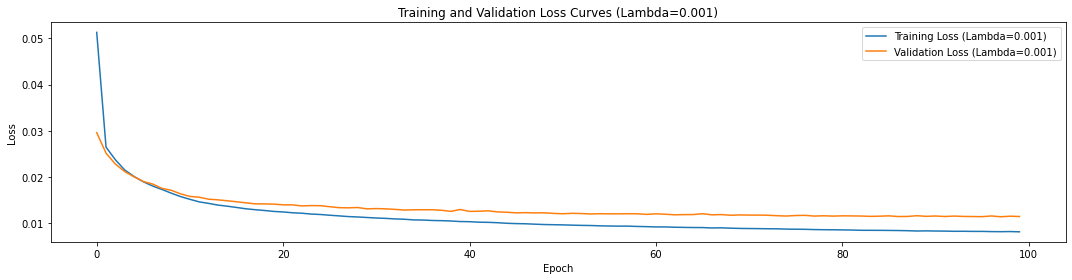

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 784)]             0         
                                                                 
 encoder (Functional)        (None, 64)                974064    
                                                                 
 decoder (Functional)        (None, 784)               974784    
                                                                 
Total params: 1,948,848
Trainable params: 1,948,848
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0503 - val_loss: 0.0289
Epoch 2/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0263 - val_loss: 0.0250
Epoch 3/100
188/188 [==============================] - 2s 11ms/step - loss: 0.0235 - val_loss: 0.0227
Epo

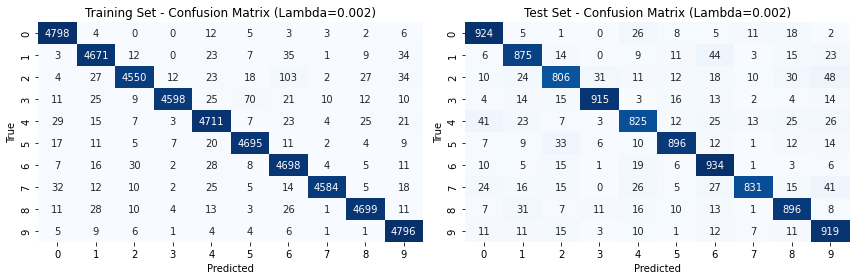

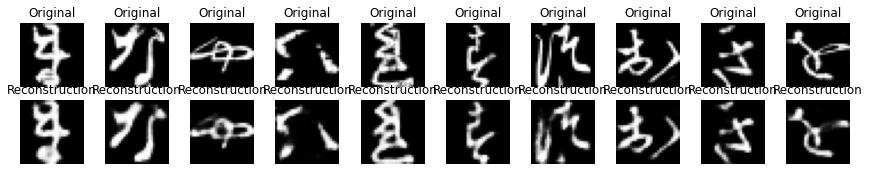

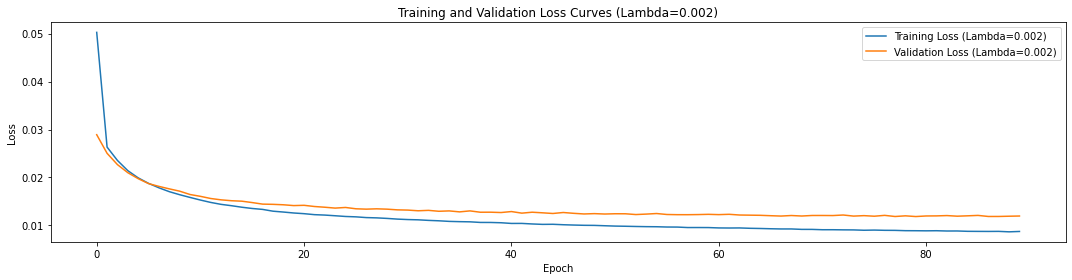

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 784)]             0         
                                                                 
 encoder (Functional)        (None, 64)                974064    
                                                                 
 decoder (Functional)        (None, 784)               974784    
                                                                 
Total params: 1,948,848
Trainable params: 1,948,848
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0516 - val_loss: 0.0295
Epoch 2/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0267 - val_loss: 0.0253
Epoch 3/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0239 - val_loss: 0.0235
Epo

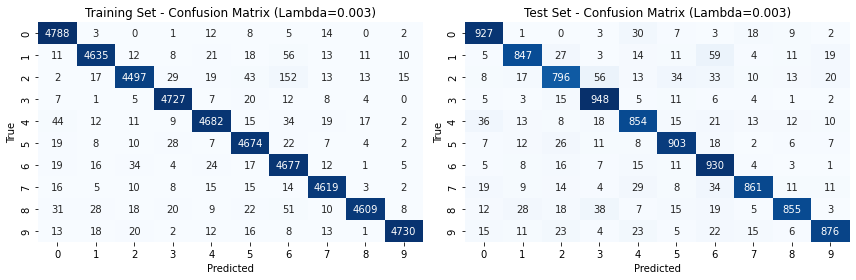

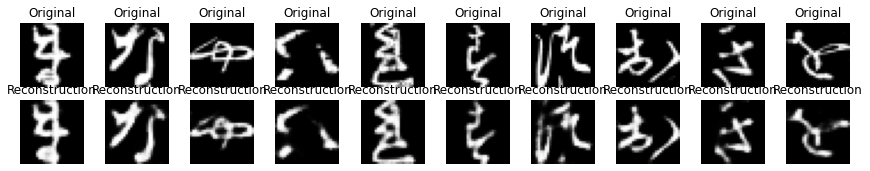

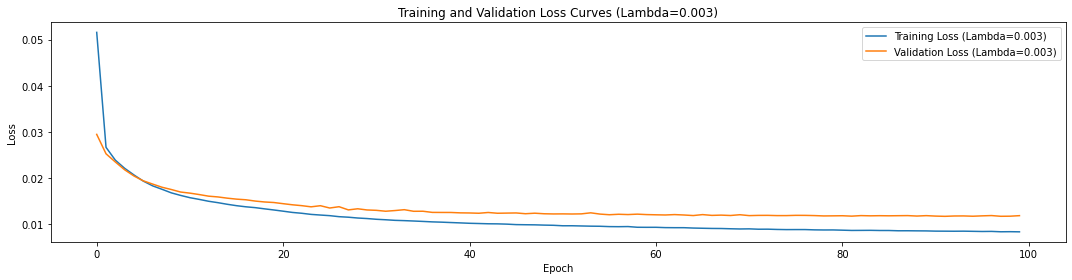

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 784)]             0         
                                                                 
 encoder (Functional)        (None, 64)                974064    
                                                                 
 decoder (Functional)        (None, 784)               974784    
                                                                 
Total params: 1,948,848
Trainable params: 1,948,848
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0517 - val_loss: 0.0303
Epoch 2/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0274 - val_loss: 0.0260
Epoch 3/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0247 - val_loss: 0.0240
Epo

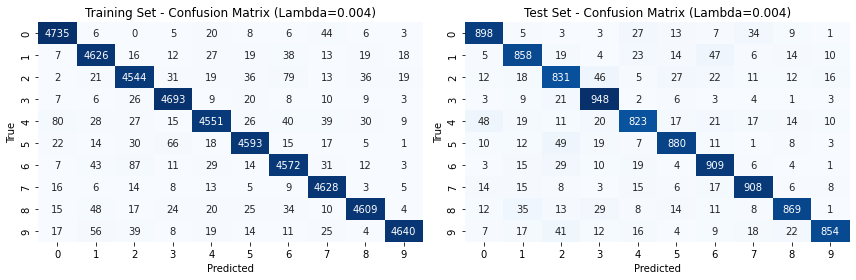

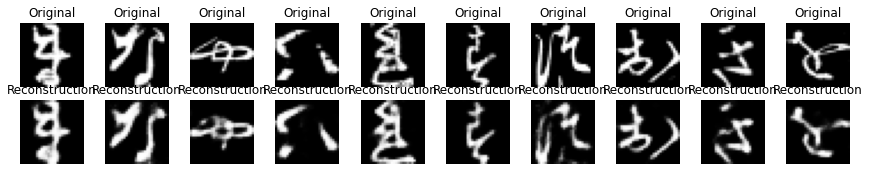

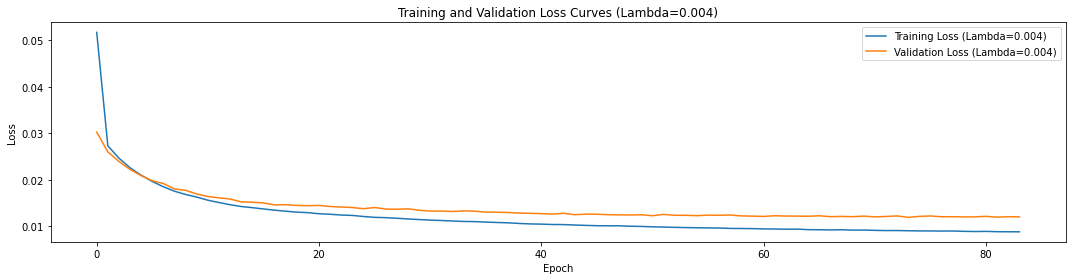

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 784)]             0         
                                                                 
 encoder (Functional)        (None, 64)                974064    
                                                                 
 decoder (Functional)        (None, 784)               974784    
                                                                 
Total params: 1,948,848
Trainable params: 1,948,848
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0518 - val_loss: 0.0302
Epoch 2/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0276 - val_loss: 0.0261
Epoch 3/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0247 - val_loss: 0.0238
Epo

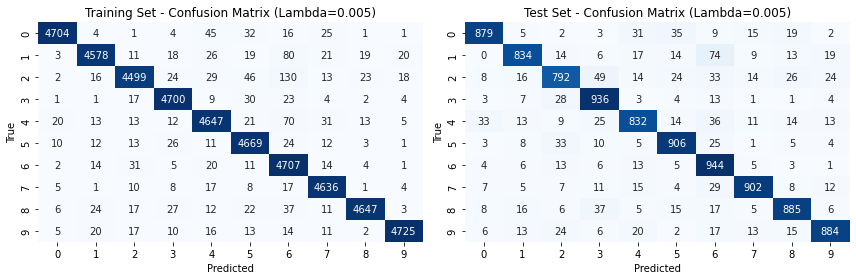

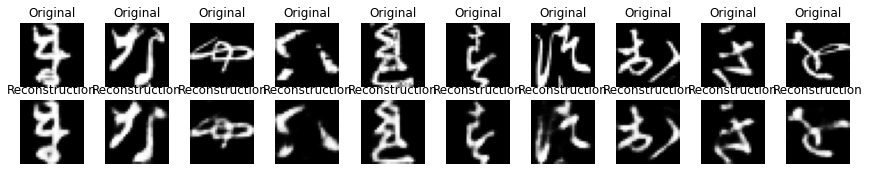

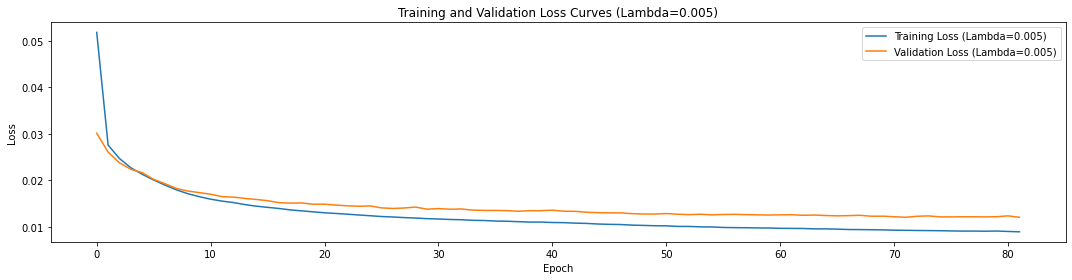

In [2]:
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Load the .npy file
file = 'encodings.npy'
encodings = np.load(file, allow_pickle=True).item()

# Extract '64' encoding for training and test sets
encoding_64_train = encodings[64][0]
encoding_64_test = encodings[64][1]

# Calculate the average encoding separately for training and test sets
average_encoding_train = np.mean(encoding_64_train, axis=0)
average_encoding_test = np.mean(encoding_64_test, axis=0)

print(average_encoding_train)
print(average_encoding_test)

def custom_regularizer(y_true, y_pred, average_encoding, lambda_values):
    total_loss_L = 0.0
    total_loss_R = 0.0

    if not isinstance(lambda_values, list):
        lambda_values = [lambda_values]
        
    for lambda_value in lambda_values:
        # Reconstruction error (L)
        loss_L = tf.reduce_mean(tf.square(y_pred - y_true))

        # Additional regularization error (R)
        loss_R = lambda_value * tf.reduce_mean(tf.square(y_pred - average_encoding))

        total_loss_L += loss_L
        total_loss_R += loss_R

    # Return the sum of reconstruction and regularization errors
    return total_loss_L / len(lambda_values) + total_loss_R / len(lambda_values)

def build_stacked_autoencoder(input_dim, encoding_dim, activation='selu', average_encoding=None, lambda_values=None):
    # Encoder
    inputs = Input(shape=(input_dim,))
    dense_1 = Dense(800, activation=activation)(inputs)
    dense_2 = Dense(400, activation=activation)(dense_1)
    encoded_layer = Dense(encoding_dim, activation=activation, activity_regularizer=lambda x: custom_regularizer(x, x, average_encoding, lambda_values))(dense_2)

    # Decoder
    encoded_input = Input(shape=(encoding_dim,))
    l_dc0 = Dense(400, activation=activation)(encoded_input)
    l_dc1 = Dense(800, activation=activation)(l_dc0)
    l_dc2 = Dense(input_dim, activation='sigmoid')(l_dc1)

    # Models
    encoder = Model(inputs, encoded_layer, name='encoder')
    decoder = Model(encoded_input, l_dc2, name='decoder')
    autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')

    return encoder, decoder, autoencoder

def plot_images_and_loss(history, decoded_imgs, x_val_flatten, lambda_value):
    # Visualize original and reconstructed images for a few examples
    num_examples = 10

    plt.figure(figsize=(15, 4))
    for i in range(num_examples):
        # Original Images
        ax = plt.subplot(3, num_examples, i + 1)
        plt.imshow(x_val_flatten[i].reshape(28, 28), cmap='gray')
        plt.title('Original')
        plt.axis('off')

        # Reconstructed Images
        ax = plt.subplot(3, num_examples, i + 1 + num_examples)
        plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
        plt.title('Reconstruction')
        plt.axis('off')

    # Plot training and validation loss curves
    plt.figure(figsize=(15, 4))
    ax = plt.subplot(1, 1, 1)
    ax.plot(history.history['loss'], label=f'Training Loss (Lambda={lambda_value})')
    ax.plot(history.history['val_loss'], label=f'Validation Loss (Lambda={lambda_value})')
    ax.set_title(f'Training and Validation Loss Curves (Lambda={lambda_value})')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()

    plt.tight_layout()
    plt.show()

def load_kmnist():
    data = {}
    data['x_train'] = np.load('./data/kmnist-train-imgs.npz')['arr_0']
    data['y_train'] = np.load('./data/kmnist-train-labels.npz')['arr_0']
    data['x_test'] = np.load('./data/kmnist-test-imgs.npz')['arr_0']
    data['y_test'] = np.load('./data/kmnist-test-labels.npz')['arr_0']
    return data

data = load_kmnist()

x_train, x_val, y_train, y_val = train_test_split(data['x_train'], data['y_train'], test_size=0.2, random_state=42)
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = data['x_test'].astype('float32') / 255.0
y_test = data['y_test']

# Autoencoder parameters
enc_dim = 64
mlp_size = 4096
encoding_dim = enc_dim
activation = 'selu'

# Build and compile the stacked autoencoder for training set with multiple lambda values
lambda_values = [0.001, 0.002, 0.003, 0.004, 0.005]

for lambda_value in lambda_values:
    encoder_train, decoder_train, autoencoder_train = build_stacked_autoencoder(
        input_dim=28*28,
        encoding_dim=encoding_dim,
        activation=activation,
        average_encoding=average_encoding_train,
        lambda_values=[lambda_value]
    )
    autoencoder_train.compile(optimizer='adam', loss="mean_squared_error", run_eagerly=True)

    # Model summary
    autoencoder_train.summary()

    # Flatten the input data to shape (None, 784)
    x_train_flatten = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))

    # Flatten the validation data to shape (None, 784)
    x_val_flatten = x_val.reshape((len(x_val), np.prod(x_val.shape[1:])))

    # Flatten the test data to shape (None, 784)
    x_test_flatten = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

    # Convert labels to one-hot encoding for training and testing sets
    y_train_one_hot = to_categorical(y_train)
    y_test_one_hot = to_categorical(y_test)
    
    # Define early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Stop training when validation loss has stopped improving
        patience=10,          # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
    )
    
    # Train the model for training set
    history_train = autoencoder_train.fit(
        x_train_flatten, x_train_flatten,
        epochs=100,
        batch_size=256,
        shuffle=True,
        validation_data=(x_val_flatten, x_val_flatten),
        callbacks=[early_stopping]  # Add early stopping callback
    )

    
    # Evaluate the model on the test set
    evaluation_train = autoencoder_train.evaluate(x_train_flatten, x_train_flatten)
    evaluation_test = autoencoder_train.evaluate(x_test_flatten, x_test_flatten)

    # Report evaluation metrics
    print(f"\nTraining Set - Loss (Lambda={lambda_value}): {evaluation_train}")
    print(f"Test Set - Loss (Lambda={lambda_value}): {evaluation_test}")

    # Encode the training and testing data
    encoded_train = encoder_train.predict(x_train_flatten)
    encoded_test = encoder_train.predict(x_test_flatten)

    num_classes = 10
    # Train a simple classifier
    classifier = tf.keras.Sequential([
        Dense(128, activation='relu', input_shape=(encoding_dim,)),
        Dense(num_classes, activation='softmax')
    ])
    classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the classifier
    classifier.fit(encoded_train, y_train, epochs=50, batch_size=256, validation_data=(encoded_test, y_test), callbacks=[early_stopping])

    # Predictions
    y_train_pred = np.argmax(classifier.predict(encoded_train), axis=1)
    y_test_pred = np.argmax(classifier.predict(encoded_test), axis=1)

    # Confusion matrices
    cm_train = confusion_matrix(y_train, y_train_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)

    print(f'Training Set - Confusion Matrix (Lambda={lambda_value})')
    print(cm_train)
    print(f'\nTesting Set - Confusion Matrix (Lambda={lambda_value})')
    print(cm_test)

    # Plot confusion matrices
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm_train, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.title(f'Training Set - Confusion Matrix (Lambda={lambda_value})')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.subplot(1, 2, 2)
    sns.heatmap(cm_test, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.title(f'Test Set - Confusion Matrix (Lambda={lambda_value})')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.tight_layout()
    plt.show()
    
    # Visualize original and reconstructed images for a few examples
    decoded_imgs = autoencoder_train.predict(x_val_flatten)
    plot_images_and_loss(history_train, decoded_imgs, x_val_flatten, lambda_value)

# Lambda = 0.001 gave perfect accuracy on training and 93.38 on validation

[ 6.958736   3.6137748  7.621929   4.4307227  7.0209637  5.9953203
  6.639212   4.527039   6.2026777  5.5690675  6.251418   6.185321
  6.0196304  6.615302   6.9763513  6.3557816  5.603314   5.3856215
  5.697649   6.135385   5.38722    6.028666   6.101485   7.987162
  6.4409585  5.968725   6.183978   6.680595   5.825424   8.184014
  7.24476    6.4850354  7.1477118  7.685853   6.7126923  6.3719864
  6.430005   6.8842936  5.689851   6.8367877  6.507872   5.5784116
  8.179685   5.4002132 10.396509   6.77899    5.3748565  7.9285636
  6.877899   7.1732736  6.459869   5.354801   8.238991   6.1210775
  5.5245376  8.24445    5.7500095  5.1092157  5.3283153  6.292792
  6.792024   6.338078   5.691143   5.9245677]
[ 6.59796    3.4241824  7.0606923  4.1209974  7.152147   6.1396966
  6.3725595  4.422325   6.0592003  5.420556   5.5711412  6.0392494
  5.923421   6.7050705  7.1076546  6.6086516  5.5177608  5.1849084
  5.367672   5.9648232  5.4402146  5.769828   5.937371   7.461755
  6.0053     5.759284

2023-11-28 00:41:29.151230: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-28 00:41:30.631626: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78911 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:87:00.0, compute capability: 8.0
2023-11-28 00:41:30.635770: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78911 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:90:00.0, compute capability: 8.0


Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 encoder (Functional)        (None, 64)                974064    
                                                                 
 decoder (Functional)        (None, 784)               974784    
                                                                 
Total params: 1,948,848
Trainable params: 1,948,848
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
 16/188 [=>............................] - ETA: 1s - loss: 0.1192

2023-11-28 00:41:32.502223: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


188/188 [==============================] - 3s 13ms/step - loss: 0.0506 - val_loss: 0.0292
Epoch 2/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0266 - val_loss: 0.0254
Epoch 3/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0239 - val_loss: 0.0233
Epoch 4/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0220 - val_loss: 0.0215
Epoch 5/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0205 - val_loss: 0.0205
Epoch 6/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0194 - val_loss: 0.0198
Epoch 7/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0184 - val_loss: 0.0188
Epoch 8/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0175 - val_loss: 0.0180
Epoch 9/100
188/188 [==============================] - 2s 11ms/step - loss: 0.0169 - val_loss: 0.0174
Epoch 10/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0163 - val_loss

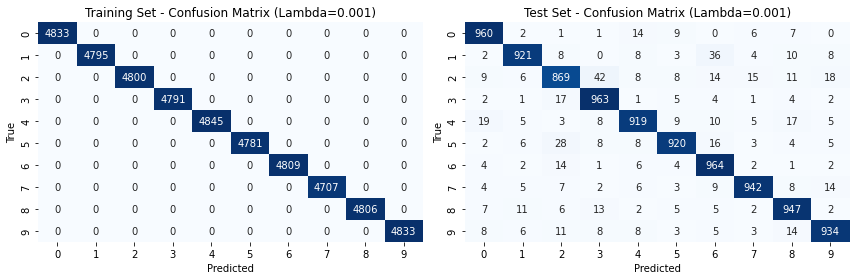

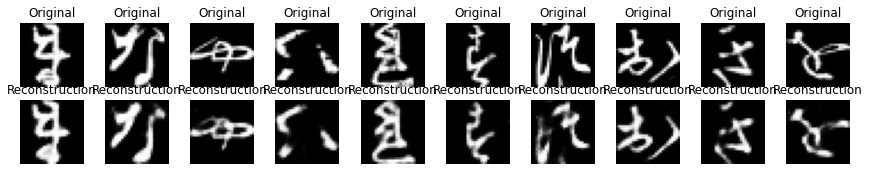

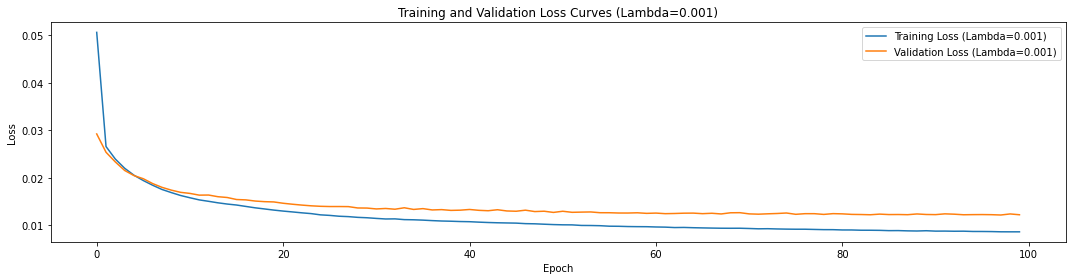

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 784)]             0         
                                                                 
 encoder (Functional)        (None, 64)                974064    
                                                                 
 decoder (Functional)        (None, 784)               974784    
                                                                 
Total params: 1,948,848
Trainable params: 1,948,848
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0509 - val_loss: 0.0295
Epoch 2/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0265 - val_loss: 0.0247
Epoch 3/100
188/188 [==============================] - 2s 13ms/step - loss: 0.0229 - val_loss: 0.0223
Epo

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Load the .npy file
file = 'encodings.npy'
encodings = np.load(file, allow_pickle=True).item()

# Extract '64' encoding for training and test sets
encoding_64_train = encodings[64][0]
encoding_64_test = encodings[64][1]

# Calculate the average encoding separately for training and test sets
average_encoding_train = np.mean(encoding_64_train, axis=0)
average_encoding_test = np.mean(encoding_64_test, axis=0)

print(average_encoding_train)
print(average_encoding_test)

def custom_regularizer(y_true, y_pred, average_encoding, lambda_values):
    total_loss_L = 0.0
    total_loss_R = 0.0

    if not isinstance(lambda_values, list):
        lambda_values = [lambda_values]
        
    for lambda_value in lambda_values:
        # Reconstruction error (L)
        loss_L = tf.reduce_mean(tf.square(y_pred - y_true))

        # Additional regularization error (R)
        loss_R = lambda_value * tf.reduce_mean(tf.square(y_pred - average_encoding))

        total_loss_L += loss_L
        total_loss_R += loss_R

    # Return the sum of reconstruction and regularization errors
    return total_loss_L / len(lambda_values) + total_loss_R / len(lambda_values)

def build_stacked_autoencoder(input_dim, encoding_dim, activation='selu', average_encoding=None, lambda_values=None):
    # Encoder
    inputs = Input(shape=(input_dim,))
    dense_1 = Dense(800, activation=activation)(inputs)
    dense_2 = Dense(400, activation=activation)(dense_1)
    encoded_layer = Dense(encoding_dim, activation=activation, activity_regularizer=lambda x: custom_regularizer(x, x, average_encoding, lambda_values))(dense_2)

    # Decoder
    encoded_input = Input(shape=(encoding_dim,))
    l_dc0 = Dense(400, activation=activation)(encoded_input)
    l_dc1 = Dense(800, activation=activation)(l_dc0)
    l_dc2 = Dense(input_dim, activation='sigmoid')(l_dc1)

    # Models
    encoder = Model(inputs, encoded_layer, name='encoder')
    decoder = Model(encoded_input, l_dc2, name='decoder')
    autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')

    return encoder, decoder, autoencoder

def plot_images_and_loss(history, decoded_imgs, x_val_flatten, lambda_value):
    # Visualize original and reconstructed images for a few examples
    num_examples = 10

    plt.figure(figsize=(15, 4))
    for i in range(num_examples):
        # Original Images
        ax = plt.subplot(3, num_examples, i + 1)
        plt.imshow(x_val_flatten[i].reshape(28, 28), cmap='gray')
        plt.title('Original')
        plt.axis('off')

        # Reconstructed Images
        ax = plt.subplot(3, num_examples, i + 1 + num_examples)
        plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
        plt.title('Reconstruction')
        plt.axis('off')

    # Plot training and validation loss curves
    plt.figure(figsize=(15, 4))
    ax = plt.subplot(1, 1, 1)
    ax.plot(history.history['loss'], label=f'Training Loss (Lambda={lambda_value})')
    ax.plot(history.history['val_loss'], label=f'Validation Loss (Lambda={lambda_value})')
    ax.set_title(f'Training and Validation Loss Curves (Lambda={lambda_value})')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()

    plt.tight_layout()
    plt.show()

def load_kmnist():
    data = {}
    data['x_train'] = np.load('./data/kmnist-train-imgs.npz')['arr_0']
    data['y_train'] = np.load('./data/kmnist-train-labels.npz')['arr_0']
    data['x_test'] = np.load('./data/kmnist-test-imgs.npz')['arr_0']
    data['y_test'] = np.load('./data/kmnist-test-labels.npz')['arr_0']
    return data

data = load_kmnist()

x_train, x_val, y_train, y_val = train_test_split(data['x_train'], data['y_train'], test_size=0.2, random_state=42)
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = data['x_test'].astype('float32') / 255.0
y_test = data['y_test']

# Autoencoder parameters
enc_dim = 64
mlp_size = 4096
encoding_dim = enc_dim
activation = 'selu'

# Build and compile the stacked autoencoder for training set with multiple lambda values
lambda_values = [0.001, 0.002, 0.003, 0.004, 0.005]

for lambda_value in lambda_values:
    encoder_train, decoder_train, autoencoder_train = build_stacked_autoencoder(
        input_dim=28*28,
        encoding_dim=encoding_dim,
        activation=activation,
        average_encoding=average_encoding_train,
        lambda_values=[lambda_value]
    )
    autoencoder_train.compile(optimizer='adam', loss="mean_squared_error", run_eagerly=True)

    # Model summary
    autoencoder_train.summary()

    # Flatten the input data to shape (None, 784)
    x_train_flatten = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))

    # Flatten the validation data to shape (None, 784)
    x_val_flatten = x_val.reshape((len(x_val), np.prod(x_val.shape[1:])))

    # Flatten the test data to shape (None, 784)
    x_test_flatten = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

    # Convert labels to one-hot encoding for training and testing sets
    y_train_one_hot = to_categorical(y_train)
    y_test_one_hot = to_categorical(y_test)
    
    # Define early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Stop training when validation loss has stopped improving
        patience=10,          # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
    )
    
    # Train the model for training set
    history_train = autoencoder_train.fit(
        x_train_flatten, x_train_flatten,
        epochs=100,
        batch_size=256,
        shuffle=True,
        validation_data=(x_val_flatten, x_val_flatten),
        callbacks=[early_stopping]  # Add early stopping callback
    )

    
    # Evaluate the model on the test set
    evaluation_train = autoencoder_train.evaluate(x_train_flatten, x_train_flatten)
    evaluation_test = autoencoder_train.evaluate(x_test_flatten, x_test_flatten)

    # Report evaluation metrics
    print(f"\nTraining Set - Loss (Lambda={lambda_value}): {evaluation_train}")
    print(f"Test Set - Loss (Lambda={lambda_value}): {evaluation_test}")

    # Encode the training and testing data
    encoded_train = encoder_train.predict(x_train_flatten)
    encoded_test = encoder_train.predict(x_test_flatten)

    num_classes = 10
    # Train a simple classifier
    classifier = tf.keras.Sequential([
        Dense(4096, activation='relu', input_shape=(encoding_dim,)),
        Dense(num_classes, activation='softmax')
    ])
    classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the classifier
    # classifier.fit(encoded_train, y_train, epochs=50, batch_size=256, validation_data=(encoded_test, y_test), callbacks=[early_stopping])
    classifier.fit(encoded_train, y_train, epochs=50, batch_size=256, validation_data=(encoded_test, y_test))

    # Predictions
    y_train_pred = np.argmax(classifier.predict(encoded_train), axis=1)
    y_test_pred = np.argmax(classifier.predict(encoded_test), axis=1)

    # Confusion matrices
    cm_train = confusion_matrix(y_train, y_train_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)

    print(f'Training Set - Confusion Matrix (Lambda={lambda_value})')
    print(cm_train)
    print(f'\nTesting Set - Confusion Matrix (Lambda={lambda_value})')
    print(cm_test)

    # Plot confusion matrices
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm_train, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.title(f'Training Set - Confusion Matrix (Lambda={lambda_value})')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.subplot(1, 2, 2)
    sns.heatmap(cm_test, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.title(f'Test Set - Confusion Matrix (Lambda={lambda_value})')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.tight_layout()
    plt.show()
    
    # Visualize original and reconstructed images for a few examples
    decoded_imgs = autoencoder_train.predict(x_val_flatten)
    plot_images_and_loss(history_train, decoded_imgs, x_val_flatten, lambda_value)

[ 6.958736   3.6137748  7.621929   4.4307227  7.0209637  5.9953203
  6.639212   4.527039   6.2026777  5.5690675  6.251418   6.185321
  6.0196304  6.615302   6.9763513  6.3557816  5.603314   5.3856215
  5.697649   6.135385   5.38722    6.028666   6.101485   7.987162
  6.4409585  5.968725   6.183978   6.680595   5.825424   8.184014
  7.24476    6.4850354  7.1477118  7.685853   6.7126923  6.3719864
  6.430005   6.8842936  5.689851   6.8367877  6.507872   5.5784116
  8.179685   5.4002132 10.396509   6.77899    5.3748565  7.9285636
  6.877899   7.1732736  6.459869   5.354801   8.238991   6.1210775
  5.5245376  8.24445    5.7500095  5.1092157  5.3283153  6.292792
  6.792024   6.338078   5.691143   5.9245677]
[ 6.59796    3.4241824  7.0606923  4.1209974  7.152147   6.1396966
  6.3725595  4.422325   6.0592003  5.420556   5.5711412  6.0392494
  5.923421   6.7050705  7.1076546  6.6086516  5.5177608  5.1849084
  5.367672   5.9648232  5.4402146  5.769828   5.937371   7.461755
  6.0053     5.759284

2023-11-28 00:52:54.165000: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-28 00:52:55.561123: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78911 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:87:00.0, compute capability: 8.0
2023-11-28 00:52:55.565574: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78911 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:90:00.0, compute capability: 8.0


Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 encoder (Functional)        (None, 64)                974064    
                                                                 
 decoder (Functional)        (None, 784)               974784    
                                                                 
Total params: 1,948,848
Trainable params: 1,948,848
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
 16/188 [=>............................] - ETA: 1s - loss: 0.1213

2023-11-28 00:52:57.441532: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


188/188 [==============================] - 3s 13ms/step - loss: 0.0506 - val_loss: 0.0293
Epoch 2/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0265 - val_loss: 0.0251
Epoch 3/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0239 - val_loss: 0.0231
Epoch 4/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0219 - val_loss: 0.0214
Epoch 5/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0202 - val_loss: 0.0202
Epoch 6/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0190 - val_loss: 0.0192
Epoch 7/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0181 - val_loss: 0.0185
Epoch 8/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0173 - val_loss: 0.0179
Epoch 9/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0167 - val_loss: 0.0175
Epoch 10/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0161 - val_loss

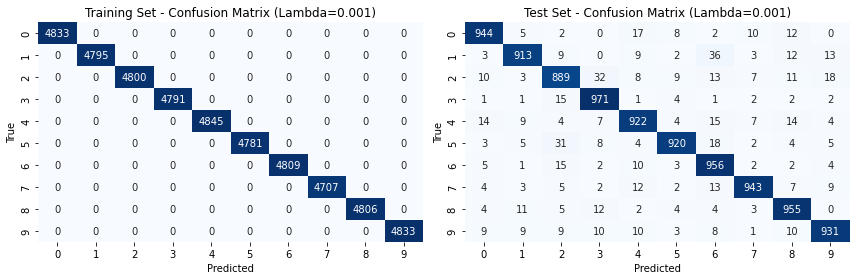

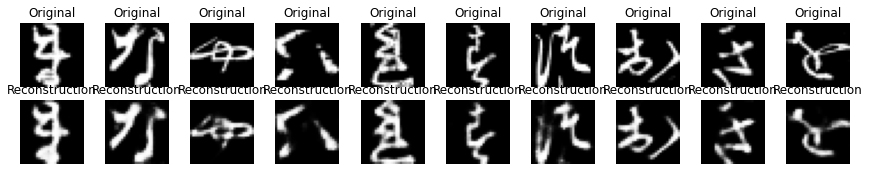

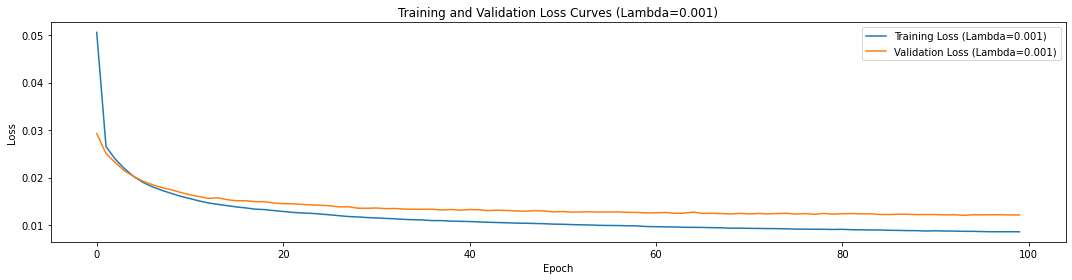

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 784)]             0         
                                                                 
 encoder (Functional)        (None, 64)                974064    
                                                                 
 decoder (Functional)        (None, 784)               974784    
                                                                 
Total params: 1,948,848
Trainable params: 1,948,848
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0515 - val_loss: 0.0306
Epoch 2/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0276 - val_loss: 0.0261
Epoch 3/100
188/188 [==============================] - 2s 13ms/step - loss: 0.0245 - val_loss: 0.0241
Epo

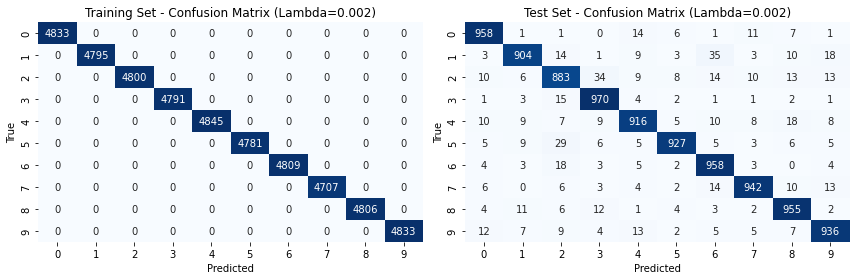

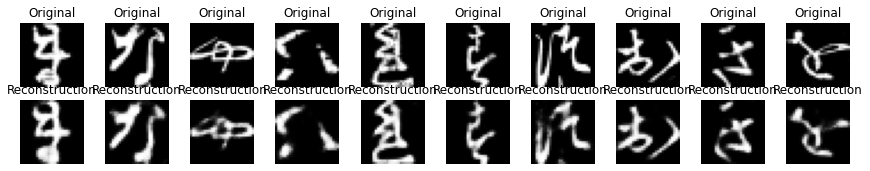

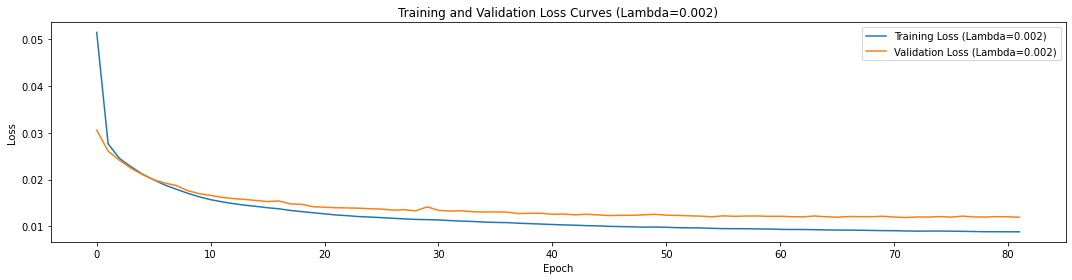

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 784)]             0         
                                                                 
 encoder (Functional)        (None, 64)                974064    
                                                                 
 decoder (Functional)        (None, 784)               974784    
                                                                 
Total params: 1,948,848
Trainable params: 1,948,848
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
188/188 [==============================] - 2s 13ms/step - loss: 0.0501 - val_loss: 0.0284
Epoch 2/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0251 - val_loss: 0.0237
Epoch 3/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0224 - val_loss: 0.0220
Epo

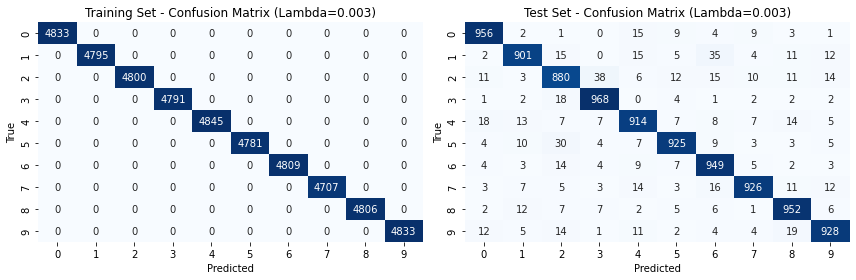

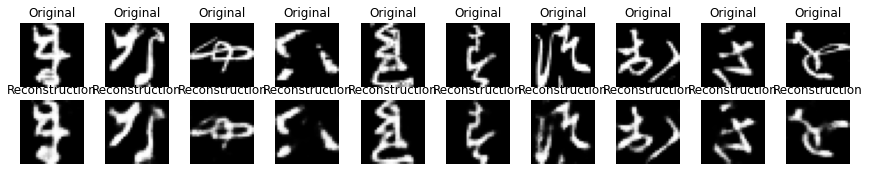

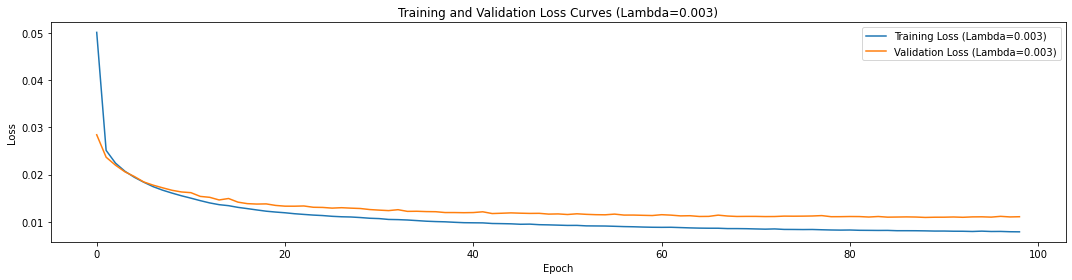

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 784)]             0         
                                                                 
 encoder (Functional)        (None, 64)                974064    
                                                                 
 decoder (Functional)        (None, 784)               974784    
                                                                 
Total params: 1,948,848
Trainable params: 1,948,848
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0501 - val_loss: 0.0291
Epoch 2/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0269 - val_loss: 0.0258
Epoch 3/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0244 - val_loss: 0.0239
Epo

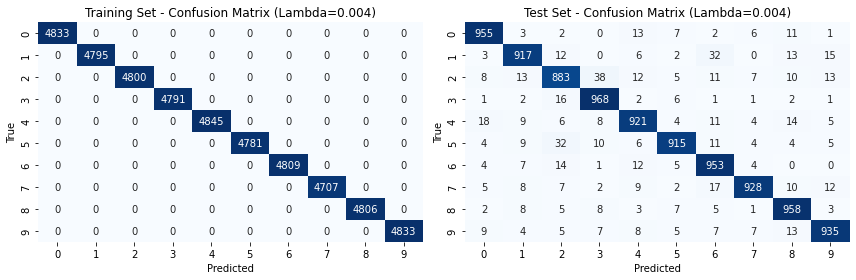

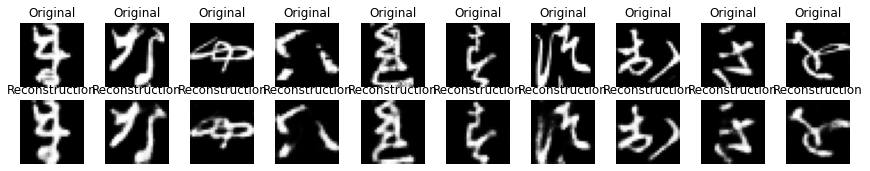

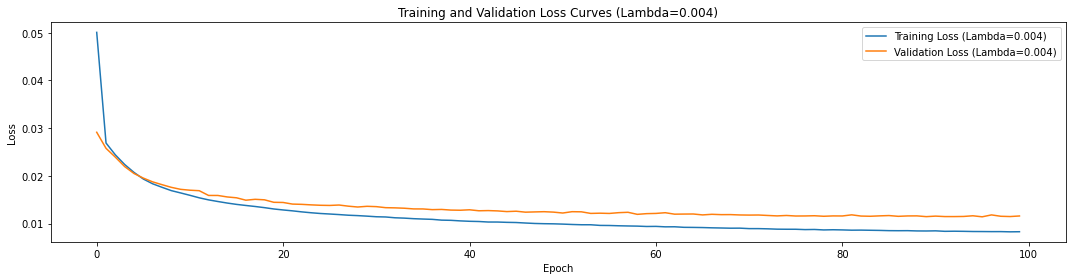

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 784)]             0         
                                                                 
 encoder (Functional)        (None, 64)                974064    
                                                                 
 decoder (Functional)        (None, 784)               974784    
                                                                 
Total params: 1,948,848
Trainable params: 1,948,848
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0513 - val_loss: 0.0302
Epoch 2/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0272 - val_loss: 0.0257
Epoch 3/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0245 - val_loss: 0.0237
Epo

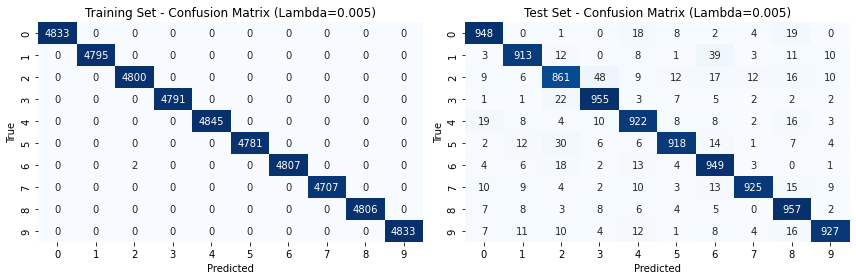

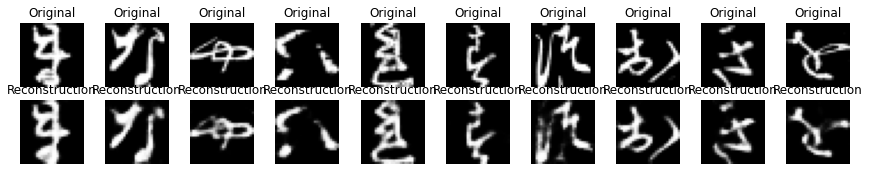

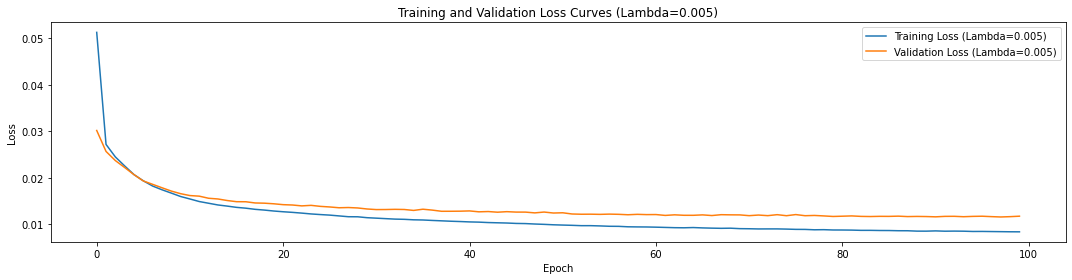

In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Load the .npy file
file = 'encodings.npy'
encodings = np.load(file, allow_pickle=True).item()

# Extract '64' encoding for training and test sets
encoding_64_train = encodings[64][0]
encoding_64_test = encodings[64][1]

# Calculate the average encoding separately for training and test sets
average_encoding_train = np.mean(encoding_64_train, axis=0)
average_encoding_test = np.mean(encoding_64_test, axis=0)

print(average_encoding_train)
print(average_encoding_test)

def custom_regularizer(y_true, y_pred, average_encoding, lambda_values):
    total_loss_L = 0.0
    total_loss_R = 0.0

    if not isinstance(lambda_values, list):
        lambda_values = [lambda_values]
        
    for lambda_value in lambda_values:
        # Reconstruction error (L)
        loss_L = tf.reduce_mean(tf.square(y_pred - y_true))

        # Additional regularization error (R)
        loss_R = lambda_value * tf.reduce_mean(tf.square(y_pred - average_encoding))

        total_loss_L += loss_L
        total_loss_R += loss_R

    # Return the sum of reconstruction and regularization errors
    return total_loss_L / len(lambda_values) + total_loss_R / len(lambda_values)

def build_stacked_autoencoder(input_dim, encoding_dim, activation='selu', average_encoding=None, lambda_values=None):
    # Encoder
    inputs = Input(shape=(input_dim,))
    dense_1 = Dense(800, activation=activation)(inputs)
    dense_2 = Dense(400, activation=activation)(dense_1)
    encoded_layer = Dense(encoding_dim, activation=activation, activity_regularizer=lambda x: custom_regularizer(x, x, average_encoding, lambda_values))(dense_2)

    # Decoder
    encoded_input = Input(shape=(encoding_dim,))
    l_dc0 = Dense(400, activation=activation)(encoded_input)
    l_dc1 = Dense(800, activation=activation)(l_dc0)
    l_dc2 = Dense(input_dim, activation='sigmoid')(l_dc1)

    # Models
    encoder = Model(inputs, encoded_layer, name='encoder')
    decoder = Model(encoded_input, l_dc2, name='decoder')
    autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')

    return encoder, decoder, autoencoder

def plot_images_and_loss(history, decoded_imgs, x_val_flatten, lambda_value):
    # Visualize original and reconstructed images for a few examples
    num_examples = 10

    plt.figure(figsize=(15, 4))
    for i in range(num_examples):
        # Original Images
        ax = plt.subplot(3, num_examples, i + 1)
        plt.imshow(x_val_flatten[i].reshape(28, 28), cmap='gray')
        plt.title('Original')
        plt.axis('off')

        # Reconstructed Images
        ax = plt.subplot(3, num_examples, i + 1 + num_examples)
        plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
        plt.title('Reconstruction')
        plt.axis('off')

    # Plot training and validation loss curves
    plt.figure(figsize=(15, 4))
    ax = plt.subplot(1, 1, 1)
    ax.plot(history.history['loss'], label=f'Training Loss (Lambda={lambda_value})')
    ax.plot(history.history['val_loss'], label=f'Validation Loss (Lambda={lambda_value})')
    ax.set_title(f'Training and Validation Loss Curves (Lambda={lambda_value})')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()

    plt.tight_layout()
    plt.show()

def load_kmnist():
    data = {}
    data['x_train'] = np.load('./data/kmnist-train-imgs.npz')['arr_0']
    data['y_train'] = np.load('./data/kmnist-train-labels.npz')['arr_0']
    data['x_test'] = np.load('./data/kmnist-test-imgs.npz')['arr_0']
    data['y_test'] = np.load('./data/kmnist-test-labels.npz')['arr_0']
    return data

data = load_kmnist()

x_train, x_val, y_train, y_val = train_test_split(data['x_train'], data['y_train'], test_size=0.2, random_state=42)
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = data['x_test'].astype('float32') / 255.0
y_test = data['y_test']

# Autoencoder parameters
enc_dim = 64
mlp_size = 4096
encoding_dim = enc_dim
activation = 'selu'

# Build and compile the stacked autoencoder for training set with multiple lambda values
lambda_values = [0.001, 0.002, 0.003, 0.004, 0.005]

for lambda_value in lambda_values:
    encoder_train, decoder_train, autoencoder_train = build_stacked_autoencoder(
        input_dim=28*28,
        encoding_dim=encoding_dim,
        activation=activation,
        average_encoding=average_encoding_train,
        lambda_values=[lambda_value]
    )
    autoencoder_train.compile(optimizer='adam', loss="mean_squared_error", run_eagerly=True)

    # Model summary
    autoencoder_train.summary()

    # Flatten the input data to shape (None, 784)
    x_train_flatten = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))

    # Flatten the validation data to shape (None, 784)
    x_val_flatten = x_val.reshape((len(x_val), np.prod(x_val.shape[1:])))

    # Flatten the test data to shape (None, 784)
    x_test_flatten = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

    # Convert labels to one-hot encoding for training and testing sets
    y_train_one_hot = to_categorical(y_train)
    y_test_one_hot = to_categorical(y_test)
    
    # Define early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Stop training when validation loss has stopped improving
        patience=10,          # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
    )
    
    # Train the model for training set
    history_train = autoencoder_train.fit(
        x_train_flatten, x_train_flatten,
        epochs=100,
        batch_size=256,
        shuffle=True,
        validation_data=(x_val_flatten, x_val_flatten),
        callbacks=[early_stopping]  # Add early stopping callback
    )

    
    # Evaluate the model on the test set
    evaluation_train = autoencoder_train.evaluate(x_train_flatten, x_train_flatten)
    evaluation_test = autoencoder_train.evaluate(x_test_flatten, x_test_flatten)

    # Report evaluation metrics
    print(f"\nTraining Set - Loss (Lambda={lambda_value}): {evaluation_train}")
    print(f"Test Set - Loss (Lambda={lambda_value}): {evaluation_test}")

    # Encode the training and testing data
    encoded_train = encoder_train.predict(x_train_flatten)
    encoded_test = encoder_train.predict(x_test_flatten)

    num_classes = 10
    # Train a simple classifier
    classifier = tf.keras.Sequential([
        Dense(4096, activation='relu', input_shape=(encoding_dim,)),
        Dense(num_classes, activation='softmax')
    ])
    classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the classifier
    # classifier.fit(encoded_train, y_train, epochs=50, batch_size=256, validation_data=(encoded_test, y_test), callbacks=[early_stopping])
    classifier.fit(encoded_train, y_train, epochs=50, batch_size=256, validation_data=(encoded_test, y_test))

    # Predictions
    y_train_pred = np.argmax(classifier.predict(encoded_train), axis=1)
    y_test_pred = np.argmax(classifier.predict(encoded_test), axis=1)

    # Confusion matrices
    cm_train = confusion_matrix(y_train, y_train_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)

    print(f'Training Set - Confusion Matrix (Lambda={lambda_value})')
    print(cm_train)
    print(f'\nTesting Set - Confusion Matrix (Lambda={lambda_value})')
    print(cm_test)

    # Plot confusion matrices
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm_train, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.title(f'Training Set - Confusion Matrix (Lambda={lambda_value})')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.subplot(1, 2, 2)
    sns.heatmap(cm_test, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.title(f'Test Set - Confusion Matrix (Lambda={lambda_value})')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.tight_layout()
    plt.show()
    
    # Visualize original and reconstructed images for a few examples
    decoded_imgs = autoencoder_train.predict(x_val_flatten)
    plot_images_and_loss(history_train, decoded_imgs, x_val_flatten, lambda_value)